In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind, f_oneway
import scipy.stats as stats

import sys
from pathlib import Path

# # Add src directory to the Python path
sys.path.append(str(Path.cwd().parent))

from src.df_data_attribute_analysis import categorize_columns

import yaml
from pathlib import Path

# Load the YAML configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Construct the path to the raw data file directly
file_path = Path("../") / config["paths"]["raw_data"] / "data.csv"

# Load the file
df = pd.read_csv(file_path)

# Display a preview of the data
df.rename(columns={'CAMPAIGN_TYPE ':'CAMPAIGN_TYPE', 'FREE TRIALS': 'FREE_TRIALS'}, inplace=True)
nsize = df.shape[0]
nsize
df

REPORT_DATE             ATL_OR_DR CAMPAIGN_TYPE      CHANNEL       COST  \
0        6/9/2023  DR - Direct Response         Title  paid social    7784.31   
1       8/29/2023  DR - Direct Response         Title          app    2474.31   
2       7/23/2023  ATL - Above The Line         Title  paid social   10222.82   
3      12/23/2023  DR - Direct Response         Title          app   49631.87   
4       8/31/2022  ATL - Above The Line         Title  paid social    2081.06   
...           ...                   ...           ...          ...        ...   
14103   2/23/2024  ATL - Above The Line         Brand         bvod    1478.78   
14104   4/21/2024  ATL - Above The Line         Title          ooh     839.25   
14105  12/13/2023  ATL - Above The Line         Title         bvod  193796.71   
14106    2/4/2023  ATL - Above The Line         Brand  paid social   84690.65   
14107   2/17/2023  DR - Direct Response         Title      youtube    7385.46   

       FREE_TRIALS  
0         86401.15  
1          2956.74  
2         12513.08  
3         17207.04  
4         21758.33  
...            ...  
14103     16941.67  
14104      5727.03  
14105     34824.51  
14106     25140.77  
14107     17770.26  

[14108 rows x 6 columns]

In [2]:
def remove_outliers_iqr(data, column, multiplier=1.5):
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers with a tighter multiplier
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Filter the DataFrame
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return filtered_data


In [3]:
# df = remove_outliers_iqr(df, 'COST', 1.0)
# df = remove_outliers_iqr(df, 'FREE_TRIALS', 1.0)
# df

In [4]:
print(f'Removed {round((nsize - df.shape[0]) / nsize * 100, 0)}%')

Removed 0.0%


In [5]:
'''
1. Data Types Breakdown:
    a. REPORT_DATE: Numerical | (Discrete -> Interval -> DateTime object)
    b. ATL_OR_DR: Categorical | (Nominal  -> String)
    c. CAMPAIGN_TYPE: Categorical | (Nominal -> String)
    d. CHANNEL: Categorical | (Nominal -> String)
    e. COST: Quantitative | (Continuous -> Ratio -> Float)
    f. FREE TRAILS: Quantitative | ( Continuous -> Ratio -> Float)

2. Data Questions/Concerns:
    a. Is 'FREE TRAILS' a generated impression count from another model? How does a free trial
    lead to continous values instead of discrete?

=> Action Items:
    a. Ensure proper data types across dataframe - DONE
    b. Identify missing data gaps - DONE
    c. Removing 0's based on EDA analysis and log transformation revealing 0 to be a major outlier. Also,
        from a logical business standpoint, doesn't seem right for a campaign to have 0 cost  especailly
        where some 0 cost campaigns generated higher than average free trials. - DONE
'''
colNames = df.columns
categorical = colNames[1:4].values.tolist()
quantitative = colNames[4::].values.tolist()

# Included holidays and Super Bowl dates with the assumption that there are more campaigns being ran during these dates
# Also assuming that holiday seasons have more cost associated with it but higher free trials being generated.
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])
us_holidays = holidays.US()
super_bowl_dates = ["2022-02-13", "2023-02-12", "2024-02-11"]
for date in super_bowl_dates:
    us_holidays[date] = "Super Bowl"
df['HOLIDAY_FLAG'] = df['REPORT_DATE'].apply(lambda x: x in us_holidays if pd.notnull(x) else False)
df['LAG_2_HOLIDAY_FLAG'] = df['REPORT_DATE'].apply(lambda x: any((x + pd.Timedelta(days=offset)) in us_holidays for offset in range(1, 3)) if pd.notnull(x) else False)
df['LEAD_2_HOLIDAY_FLAG'] = df['REPORT_DATE'].apply(lambda x: any((x - pd.Timedelta(days=offset)) in us_holidays for offset in range(1, 3)) if pd.notnull(x) else False)
df['HOLIDAY_FLAG'] = df[['HOLIDAY_FLAG', 'LAG_2_HOLIDAY_FLAG', 'LAG_2_HOLIDAY_FLAG']].any(axis=1)
df.drop(columns=['LAG_2_HOLIDAY_FLAG', 'LEAD_2_HOLIDAY_FLAG'], inplace=True)

# Extract the month and season from the date to get better insights from metadata.
month_to_season = {
    1: "Winter",
    2: "Winter",
    3: "Spring",
    4: "Spring",
    5: "Spring",
    6: "Summer",
    7: "Summer",
    8: "Summer",
    9: "Fall",
    10: "Fall",
    11: "Fall",
    12: "Winter"
}
#df['SEASON'] = df['REPORT_DATE'].dt.month.map(month_to_season)
df['MONTH'] = df['REPORT_DATE'].dt.month_name()

# Combine categorical data for feature engineering to capture larger groups/trends:
# Targeted 'CHANNEL' since that showed slight more relationship with free trial and
# cost with other categorical variables.
#df['CHANNEL_ATL_OR_DR'] = df['CHANNEL'] + '_' + df['ATL_OR_DR']
#df['CHANNEL_CAMPAIGN_TYPE'] = df['CHANNEL'] + '_' + df['CAMPAIGN_TYPE']

categorical.append('MONTH')#categorical.extend(['HOLIDAY_FLAG', 'MONTH'])

def generate_combinations(categorical):
    def backtrack(start, path):
        # Append the current path (combination) to the result
        result.append(path[:])

        # Explore further combinations by including elements one by one
        for i in range(start, len(categorical)):
            # Include the current element
            path.append(categorical[i])

            # Recurse with the updated path
            backtrack(i + 1, path)

            # Backtrack: remove the last element to explore other combinations
            path.pop()

    # Result to store all combinations
    result = []
    # Start the DFS/backtracking
    backtrack(0, [])
    return result

combinations = generate_combinations(categorical)

# Print all combinations
for combo in combinations:
    print(combo)

for combo in combinations:
    # Ensure the combination has unique column names
    if len(combo) != len(set(combo)):
        continue  # Skip combinations with duplicate column names

    # Generate the column name
    column_name = '_'.join(combo)

    # Skip if the combination is empty, already exists, or is single-element
    if not combo or column_name in df.columns or len(combo) == 1:
        continue

    # Simplified row-by-row logic to create the new column
    new_column = []
    for index in range(len(df)):
        concatenated_value = ""
        for col in combo:
            if concatenated_value == "":
                concatenated_value = str(df.loc[index, col])
            else:
                concatenated_value += "_" + str(df.loc[index, col])
        new_column.append(concatenated_value)

    # Add the new column to the DataFrame
    df[column_name] = new_column

# Combine numerical data for feature engineering:
# Created KPI metric efficency cost per free trial generated
df['COST_PER_FREE_TRIALS'] = df['COST'] / df['FREE_TRIALS']
df['COST_BY_FREE_TRIALS'] = df['COST'] * df['FREE_TRIALS']
quantitative.extend(['COST_PER_FREE_TRIALS','COST_BY_FREE_TRIALS'])

# Results
print(f'Categorical | {len(categorical)}: {categorical}\nQuantitative | {len(quantitative)}: {quantitative} \n')
print(f'Table Dimension: {df.shape} \n')
df.info()

[]
['ATL_OR_DR']
['ATL_OR_DR', 'CAMPAIGN_TYPE']
['ATL_OR_DR', 'CAMPAIGN_TYPE', 'CHANNEL']
['ATL_OR_DR', 'CAMPAIGN_TYPE', 'CHANNEL', 'MONTH']
['ATL_OR_DR', 'CAMPAIGN_TYPE', 'MONTH']
['ATL_OR_DR', 'CHANNEL']
['ATL_OR_DR', 'CHANNEL', 'MONTH']
['ATL_OR_DR', 'MONTH']
['CAMPAIGN_TYPE']
['CAMPAIGN_TYPE', 'CHANNEL']
['CAMPAIGN_TYPE', 'CHANNEL', 'MONTH']
['CAMPAIGN_TYPE', 'MONTH']
['CHANNEL']
['CHANNEL', 'MONTH']
['MONTH']
Categorical | 4: ['ATL_OR_DR', 'CAMPAIGN_TYPE', 'CHANNEL', 'MONTH']
Quantitative | 4: ['COST', 'FREE_TRIALS', 'COST_PER_FREE_TRIALS', 'COST_BY_FREE_TRIALS'] 

Table Dimension: (14108, 21) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14108 entries, 0 to 14107
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   REPORT_DATE                            14108 non-null  datetime64[ns]
 1   ATL_OR_DR                              14108 non-null

In [6]:
df

REPORT_DATE             ATL_OR_DR CAMPAIGN_TYPE      CHANNEL       COST  \
0      2023-06-09  DR - Direct Response         Title  paid social    7784.31   
1      2023-08-29  DR - Direct Response         Title          app    2474.31   
2      2023-07-23  ATL - Above The Line         Title  paid social   10222.82   
3      2023-12-23  DR - Direct Response         Title          app   49631.87   
4      2022-08-31  ATL - Above The Line         Title  paid social    2081.06   
...           ...                   ...           ...          ...        ...   
14103  2024-02-23  ATL - Above The Line         Brand         bvod    1478.78   
14104  2024-04-21  ATL - Above The Line         Title          ooh     839.25   
14105  2023-12-13  ATL - Above The Line         Title         bvod  193796.71   
14106  2023-02-04  ATL - Above The Line         Brand  paid social   84690.65   
14107  2023-02-17  DR - Direct Response         Title      youtube    7385.46   

       FREE_TRIALS  HOLIDAY_FLAG     MONTH     ATL_OR_DR_CAMPAIGN_TYPE  \
0         86401.15         False      June  DR - Direct Response_Title   
1          2956.74         False    August  DR - Direct Response_Title   
2         12513.08         False      July  ATL - Above The Line_Title   
3         17207.04          True  December  DR - Direct Response_Title   
4         21758.33         False    August  ATL - Above The Line_Title   
...            ...           ...       ...                         ...   
14103     16941.67         False  February  ATL - Above The Line_Brand   
14104      5727.03         False     April  ATL - Above The Line_Title   
14105     34824.51         False  December  ATL - Above The Line_Title   
14106     25140.77         False  February  ATL - Above The Line_Brand   
14107     17770.26         False  February  DR - Direct Response_Title   

              ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL  ...  \
0      DR - Direct Response_Title_paid social  ...   
1              DR - Direct Response_Title_app  ...   
2      ATL - Above The Line_Title_paid social  ...   
3              DR - Direct Response_Title_app  ...   
4      ATL - Above The Line_Title_paid social  ...   
...                                       ...  ...   
14103         ATL - Above The Line_Brand_bvod  ...   
14104          ATL - Above The Line_Title_ooh  ...   
14105         ATL - Above The Line_Title_bvod  ...   
14106  ATL - Above The Line_Brand_paid social  ...   
14107      DR - Direct Response_Title_youtube  ...   

             ATL_OR_DR_CAMPAIGN_TYPE_MONTH                 ATL_OR_DR_CHANNEL  \
0          DR - Direct Response_Title_June  DR - Direct Response_paid social   
1        DR - Direct Response_Title_August          DR - Direct Response_app   
2          ATL - Above The Line_Title_July  ATL - Above The Line_paid social   
3      DR - Direct Response_Title_December          DR - Direct Response_app   
4        ATL - Above The Line_Title_August  ATL - Above The Line_paid social   
...                                    ...                               ...   
14103  ATL - Above The Line_Brand_February         ATL - Above The Line_bvod   
14104     ATL - Above The Line_Title_April          ATL - Above The Line_ooh   
14105  ATL - Above The Line_Title_December         ATL - Above The Line_bvod   
14106  ATL - Above The Line_Brand_February  ATL - Above The Line_paid social   
14107  DR - Direct Response_Title_February      DR - Direct Response_youtube   

                         ATL_OR_DR_CHANNEL_MONTH  \
0          DR - Direct Response_paid social_June   
1                DR - Direct Response_app_August   
2          ATL - Above The Line_paid social_July   
3              DR - Direct Response_app_December   
4        ATL - Above The Line_paid social_August   
...                                          ...   
14103         ATL - Above The Line_bvod_February   
14104             ATL - Above The Line_ooh_April   
14105         ATL - Above The Line_bvod_December   
14106  ATL - A

### Univariate Analysis on Continuous Data

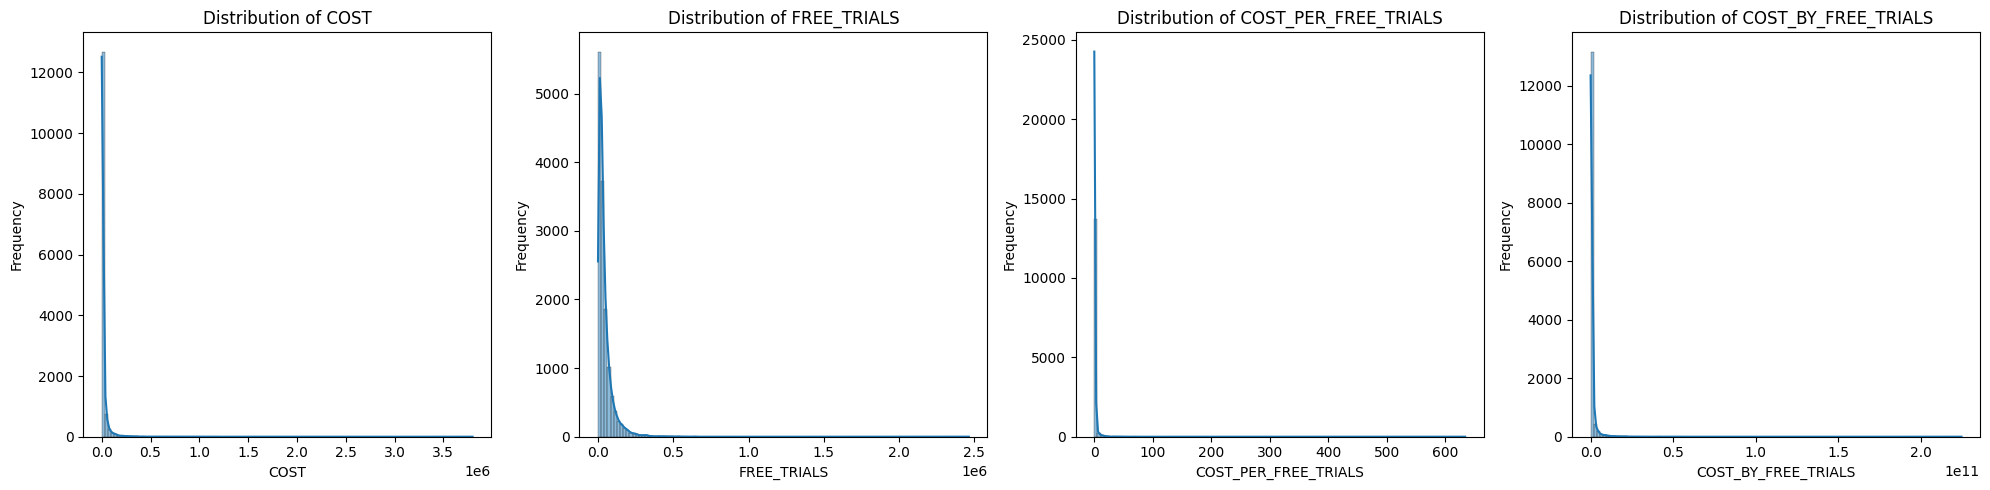

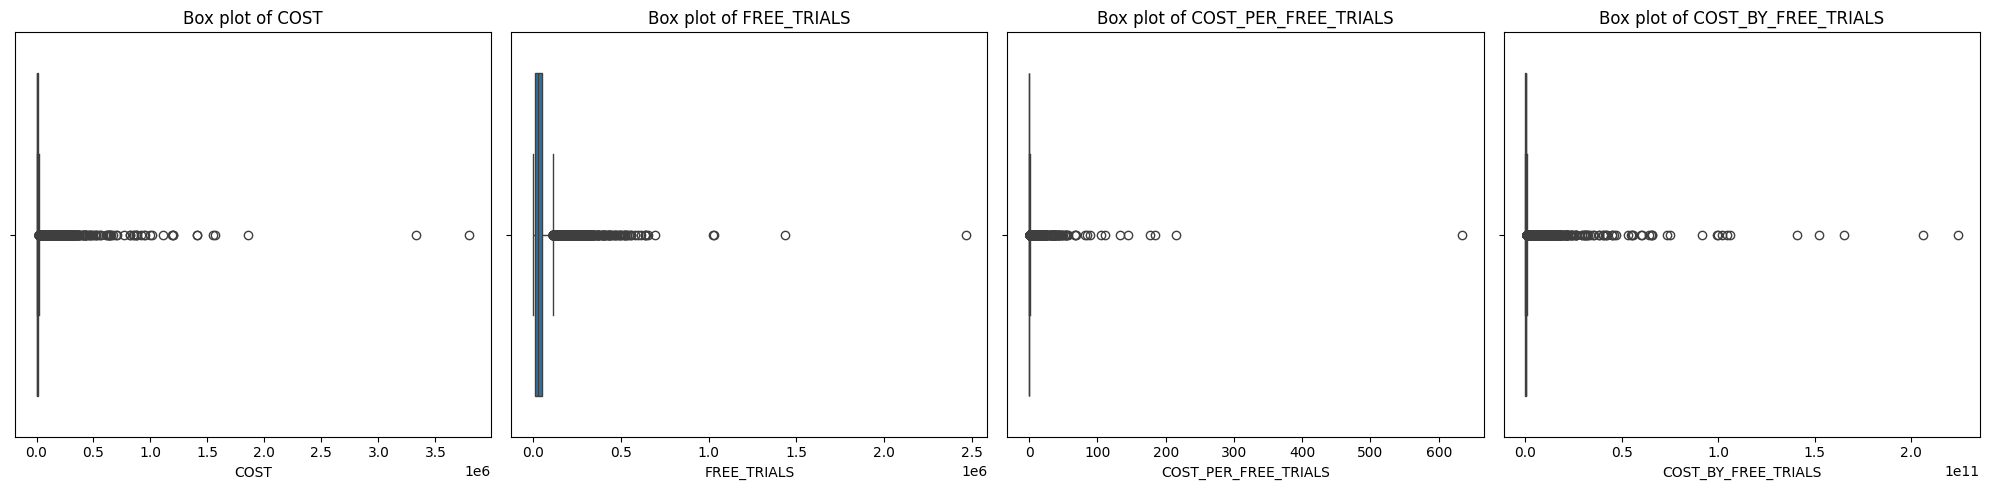

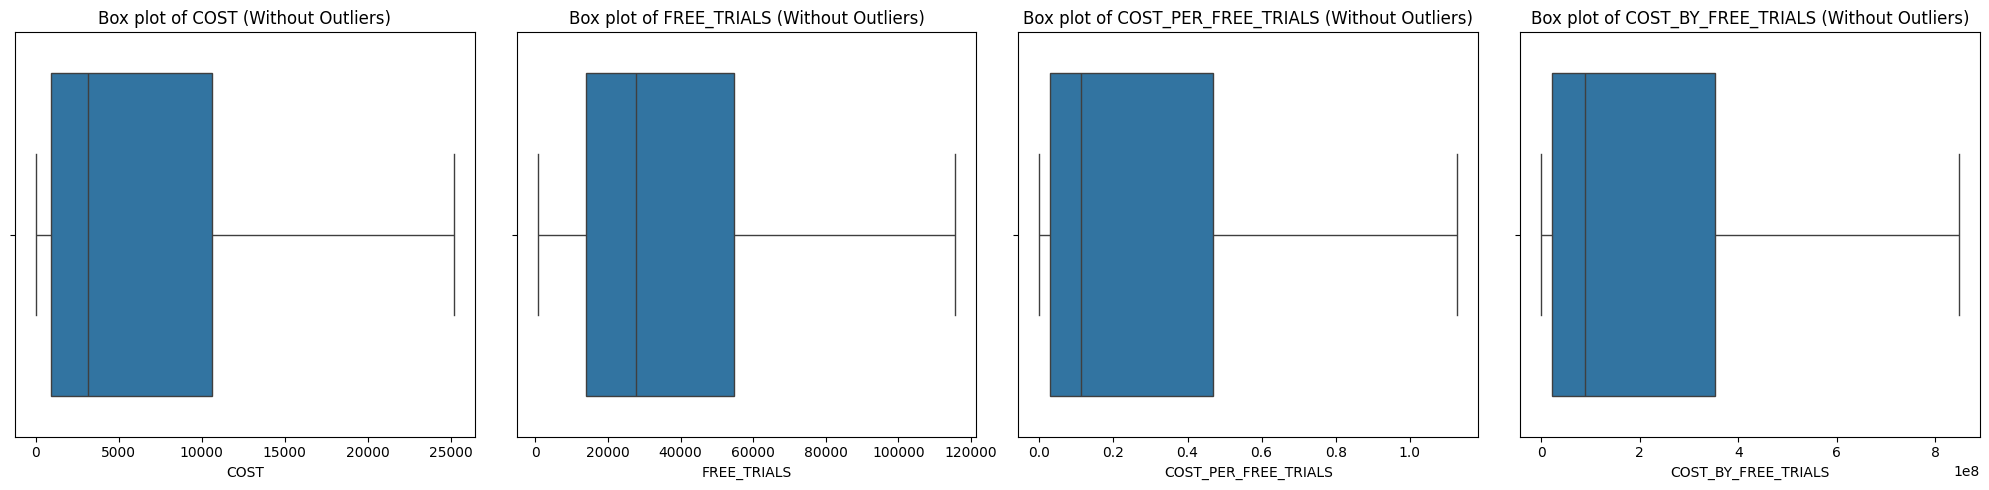

COST   FREE_TRIALS  COST_PER_FREE_TRIALS  COST_BY_FREE_TRIALS
count  1.410800e+04  1.410800e+04          14108.000000         1.410800e+04
mean   1.655741e+04  4.545834e+04              0.964311         7.898312e+08
std    7.359892e+04  6.040529e+04              7.217306         4.949440e+09
min    0.000000e+00  5.762400e+02              0.000000         0.000000e+00
25%    9.457675e+02  1.393528e+04              0.028652         2.165098e+07
50%    3.164070e+03  2.777694e+04              0.113137         8.822948e+07
75%    1.064149e+04  5.467904e+04              0.469016         3.538239e+08
max    3.798940e+06  2.463082e+06            634.101017         2.245760e+11

In [7]:
'''
Single Variation Continuous Analysis via Histogram/Boxplots:

1. All visuals shows a right skewed distribution with outliers on the right side. So, the mean will be greater than the median.

2. All visuals show data points are clustered around the lower ends and extreme outliers causing the positive skewness.

3. The max values for all data, (COST = 3M, FREE_TRIALS = 2M), are significantly larger than the  (IQR) and mean values,
validating the outliers. More analysis is needed to determine if these should be removed or kept.

4. With such skewness, median would be a more viable measure of central tendency than the mean.

5. Most of the cluster of COST is around 0 which is surprising because I wouldn't have guessed the majority of campaigns to incur 0 expenses.
Is 0 a placeholder for missing data?

6.  All visuals violates Linear Regression's assumption of normality. Need to log transform this feature to normalize the data and reduce outlier
impact

7. FREE TRIALS has a broader distribution of values giving incentives to companies/clients to really optimize their campaign stratgey.
This also signals that some campaigns can also genterate minimal free trials.

8. COST is more concentrated near zero. This tell us that it's either relatively inexpensive and consistent when it comes the cost of runnning a
campaign or companies aren't allocating enough to run campaigns.

9. The lowest free trial generated for a campaign is 500. Interesting it's not 0 unlike COST. Is 500 suppose to repersent 0?

10. A lot of outliers are visible in boxplot visuals. The fact that we have a lot of points clustered around the upper whisker makes me thinks
there is an actual reason behind such concentration of data points for cost and free trials. (IE: Segmentation Analysis)

11. COST/FREE TRIALS are generally on the lower end. We don't see a lot of campaigns being exorbitantly expensive or generating a lot of free trials.
    a. Campaigns generally cost $5,000-$10,000
    b. campaings genearlly generate 20,000-40,000 free trials
    c. having smaller values means more efficency.

12. What separates the pack of companies/clients that are spending exorbitant amount on campaaigns? What/why are they doing differently?

=> Action Items:
    a. Log Transformation on 'COST' and 'FREE TRIALS'. - DONE
    b. Single Variation Continuous Analysis using boxplots - DONE
    c. Covaritation Continuous Analysis between 'COST' and 'FREE TRIALS' using a scatterplot. - DONE
    d. Validate assumption that cost and free trials doesn't have a strong linear relationship. - DONE
    e. Create low, medium, high spenders as binning categories for COST. Can be usefulr for customer
    segmentation analysis
'''
# Create a grid layout
num_cols = len(quantitative)
ncols = 4  # Set the number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Adjust rows dynamically based on total columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))  # Wider figure for 4 columns

# Plot each quantitative column
for i, quant_col in enumerate(quantitative):
    sns.histplot(df[quant_col], kde=True, bins=118, ax=axes[i]) #118 bins | bin size ~= SqRoot(n):
    axes[i].set_title(f'Distribution of {quant_col}')
    axes[i].set_xlabel(quant_col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

num_cols = len(quantitative)
ncols = 4  # Number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Adjust rows dynamically
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# Plot each quantitative column
for i, col in enumerate(quantitative):
    sns.boxplot(x=col, data=df, ax=axes[i])  # Removed palette argument
    axes[i].set_title(f'Box plot of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

# Repeat for boxplots without outliers
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flatten() if nrows * ncols > 1 else [axes]

for i, col in enumerate(quantitative):
    sns.boxplot(x=col, data=df, showfliers=False, ax=axes[i])  # Removed palette argument
    axes[i].set_title(f'Box plot of {col} (Without Outliers)')
    axes[i].set_xlabel(col)


plt.tight_layout()
plt.show()
df[quantitative].describe()


In [8]:
np.exp(2)-1

6.38905609893065

In [9]:
np.exp(14)-1

1202603.2841647768

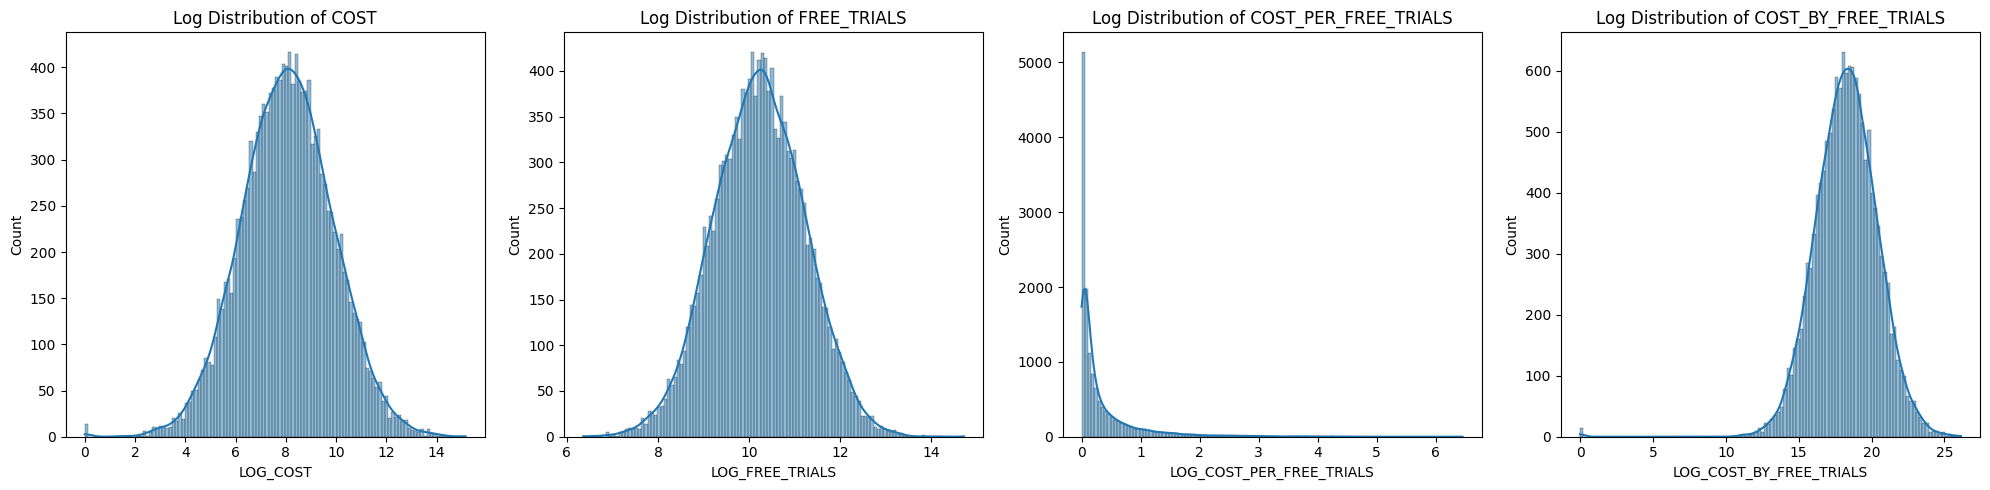

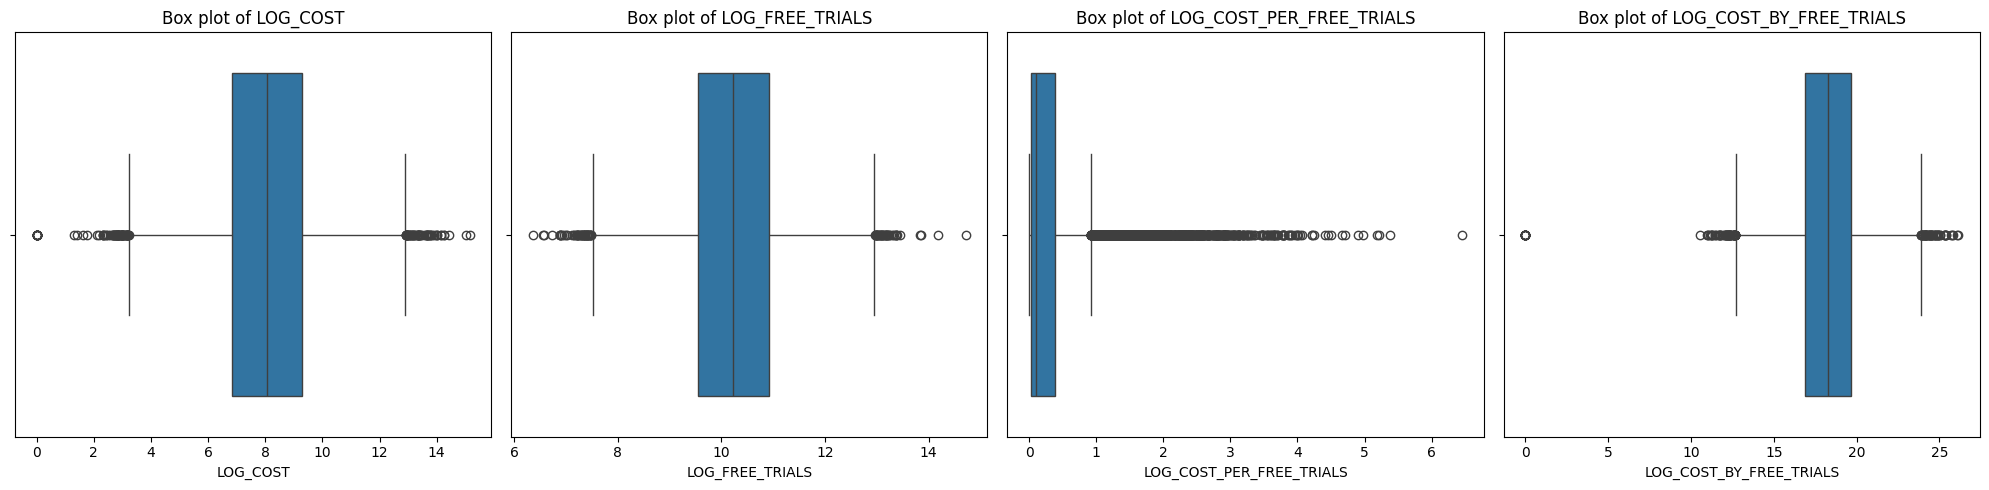

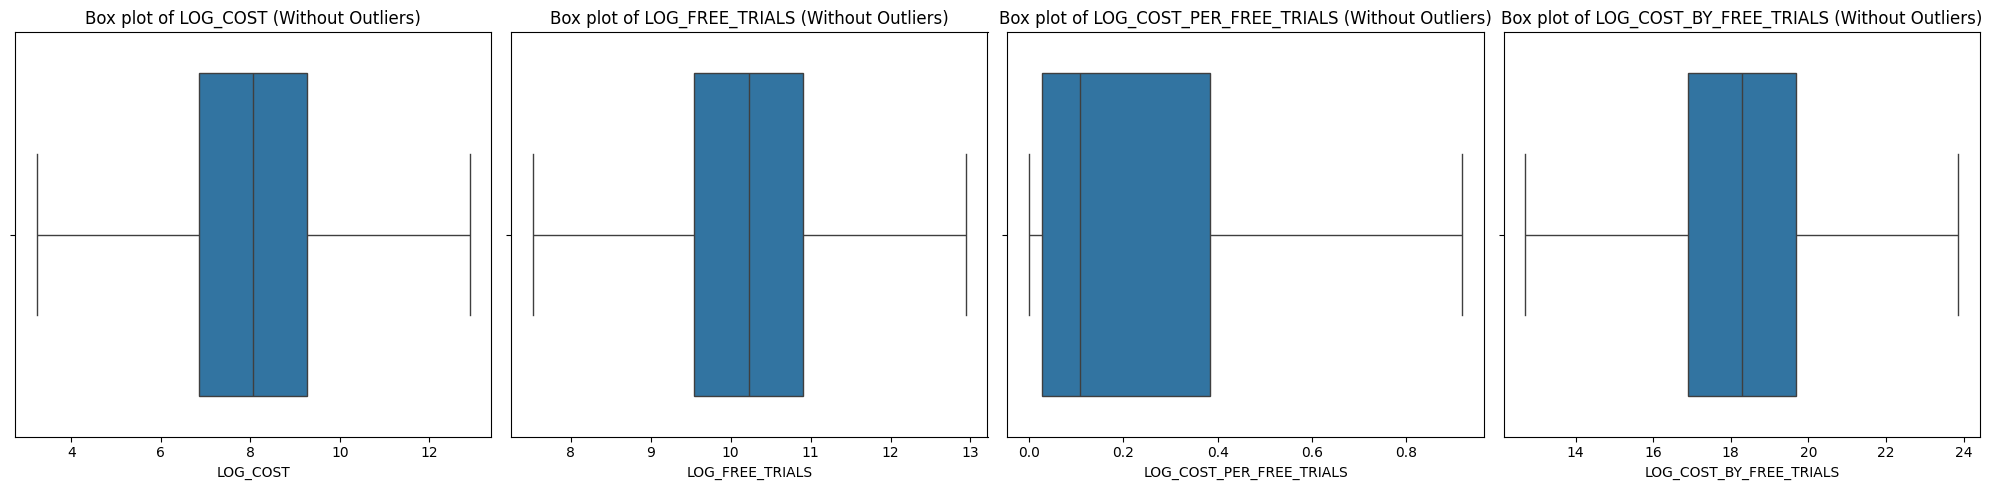

COST   FREE_TRIALS  COST_PER_FREE_TRIALS  COST_BY_FREE_TRIALS
count  1.410800e+04  1.410800e+04          14108.000000         1.410800e+04
mean   1.655741e+04  4.545834e+04              0.964311         7.898312e+08
std    7.359892e+04  6.040529e+04              7.217306         4.949440e+09
min    0.000000e+00  5.762400e+02              0.000000         0.000000e+00
25%    9.457675e+02  1.393528e+04              0.028652         2.165098e+07
50%    3.164070e+03  2.777694e+04              0.113137         8.822948e+07
75%    1.064149e+04  5.467904e+04              0.469016         3.538239e+08
max    3.798940e+06  2.463082e+06            634.101017         2.245760e+11

In [10]:
'''
Single Variation LOG-Continuous Analysis via Histogram/Boxplots:

1. The log transformation has normalized the data and reduced the impact of outliers. The distribution is now more symmetrical.

2. Cost Data: 68% of all campaigns to fall within one standard deviation of this range $402 -$22,025; the mean/median is $3,000.

3. Free Trials: 68% of all campaigns to fall within one standard deviation of this range 3,000 - 160,000; the mean/median is 22,000.

4. Free Trials has a broader distribution of values than Cost, which validates visuals seen already. You can spend a fixed cost but
have higher variance in free trials generated. This tells us cost is not a good indicator of free trials generated and that there are
more factors at play.

5. The log boxplots still show outliers but now on both tails except for LOG_COST_PER_TRIALS. Left tail might not offer much savings opportunities,
but the right tail might provide opportunities to reduce expenses or look into a more cost savings campaign strategy. The fact that there are low
variances in both tails of log cost and log free trial this could be some clustering behavior.

6. Segmenting data into 2 groups for cost and free trials would be a good baseline for segmentation before running clustering algorithms. 2 groups
refering to your typical spenders and then your abnormal spenders. Can also use 3 groups for low, medium, high costing campaigns and free trials
generated.

7. LOG_COST_PER_TRIALS has less variance than the other log-transformed variables. This could be due to the fact many comapnies adopt similar
startegies/themes/objectives regarding striving for efficent cost per free trial. However, we do have a bucnh of exterme outliers that are
inefficent. Thiscould liely be either misallocation of resources/stategy, or these companies can afford to spend more on campaigns.

8. The fact that there are so many present outliers on oppsoite whiskers for most visuals makes me think these are more than just outliers and
instead suggests distinct business segments/behavioral clusters and/or domain behavior.

=>. Action Items:
    a. Add cateogircal data to the scatterplot to see if there are any relationships between the two.
    b. Filter data on 0's in 'LOG_COST' for more analysis.
    c. Filter data on high 'LOG_COST' with low 'LOG_FREE TRIALS' for more analysis.
    d. Filter data on low 'LOG_COST' and high 'LOG_FREE TRIALS' for more analysis.
    e. Deal with outliers - DONE

'''
num_cols = len(quantitative)
ncols = 4  # Number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Dynamically adjust rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# Flatten axes for iteration
axes = axes.flatten()

# Plot histograms for log-transformed variables
for i, quant_col in enumerate(quantitative):
    log_transformed = np.log1p(df[quant_col])  # Log-transform
    df[f'LOG_{quant_col}'] = log_transformed  # Add to dataframe
    sns.histplot(log_transformed, kde=True, bins=118, ax=axes[i])
    axes[i].set_title(f'Log Distribution of {quant_col}')
    axes[i].set_xlabel(f'LOG_{quant_col}')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

num_cols = len(quantitative)
ncols = 4
nrows = (num_cols // ncols) + (num_cols % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

axes = axes.flatten()

for i, col in enumerate(quantitative):
    sns.boxplot(x=df[f'LOG_{col}'], data=df, ax=axes[i])
    axes[i].set_title(f'Box plot of LOG_{col}')
    axes[i].set_xlabel(f'LOG_{col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
for i, col in enumerate(quantitative):
    sns.boxplot(x=df[f'LOG_{col}'], data=df, showfliers=False, ax=axes[i])
    axes[i].set_title(f'Box plot of LOG_{col} (Without Outliers)')
    axes[i].set_xlabel(f'LOG_{col}')


plt.tight_layout()
plt.show()

df[quantitative].describe()


### MultiVariate Analysis on Continuous Data

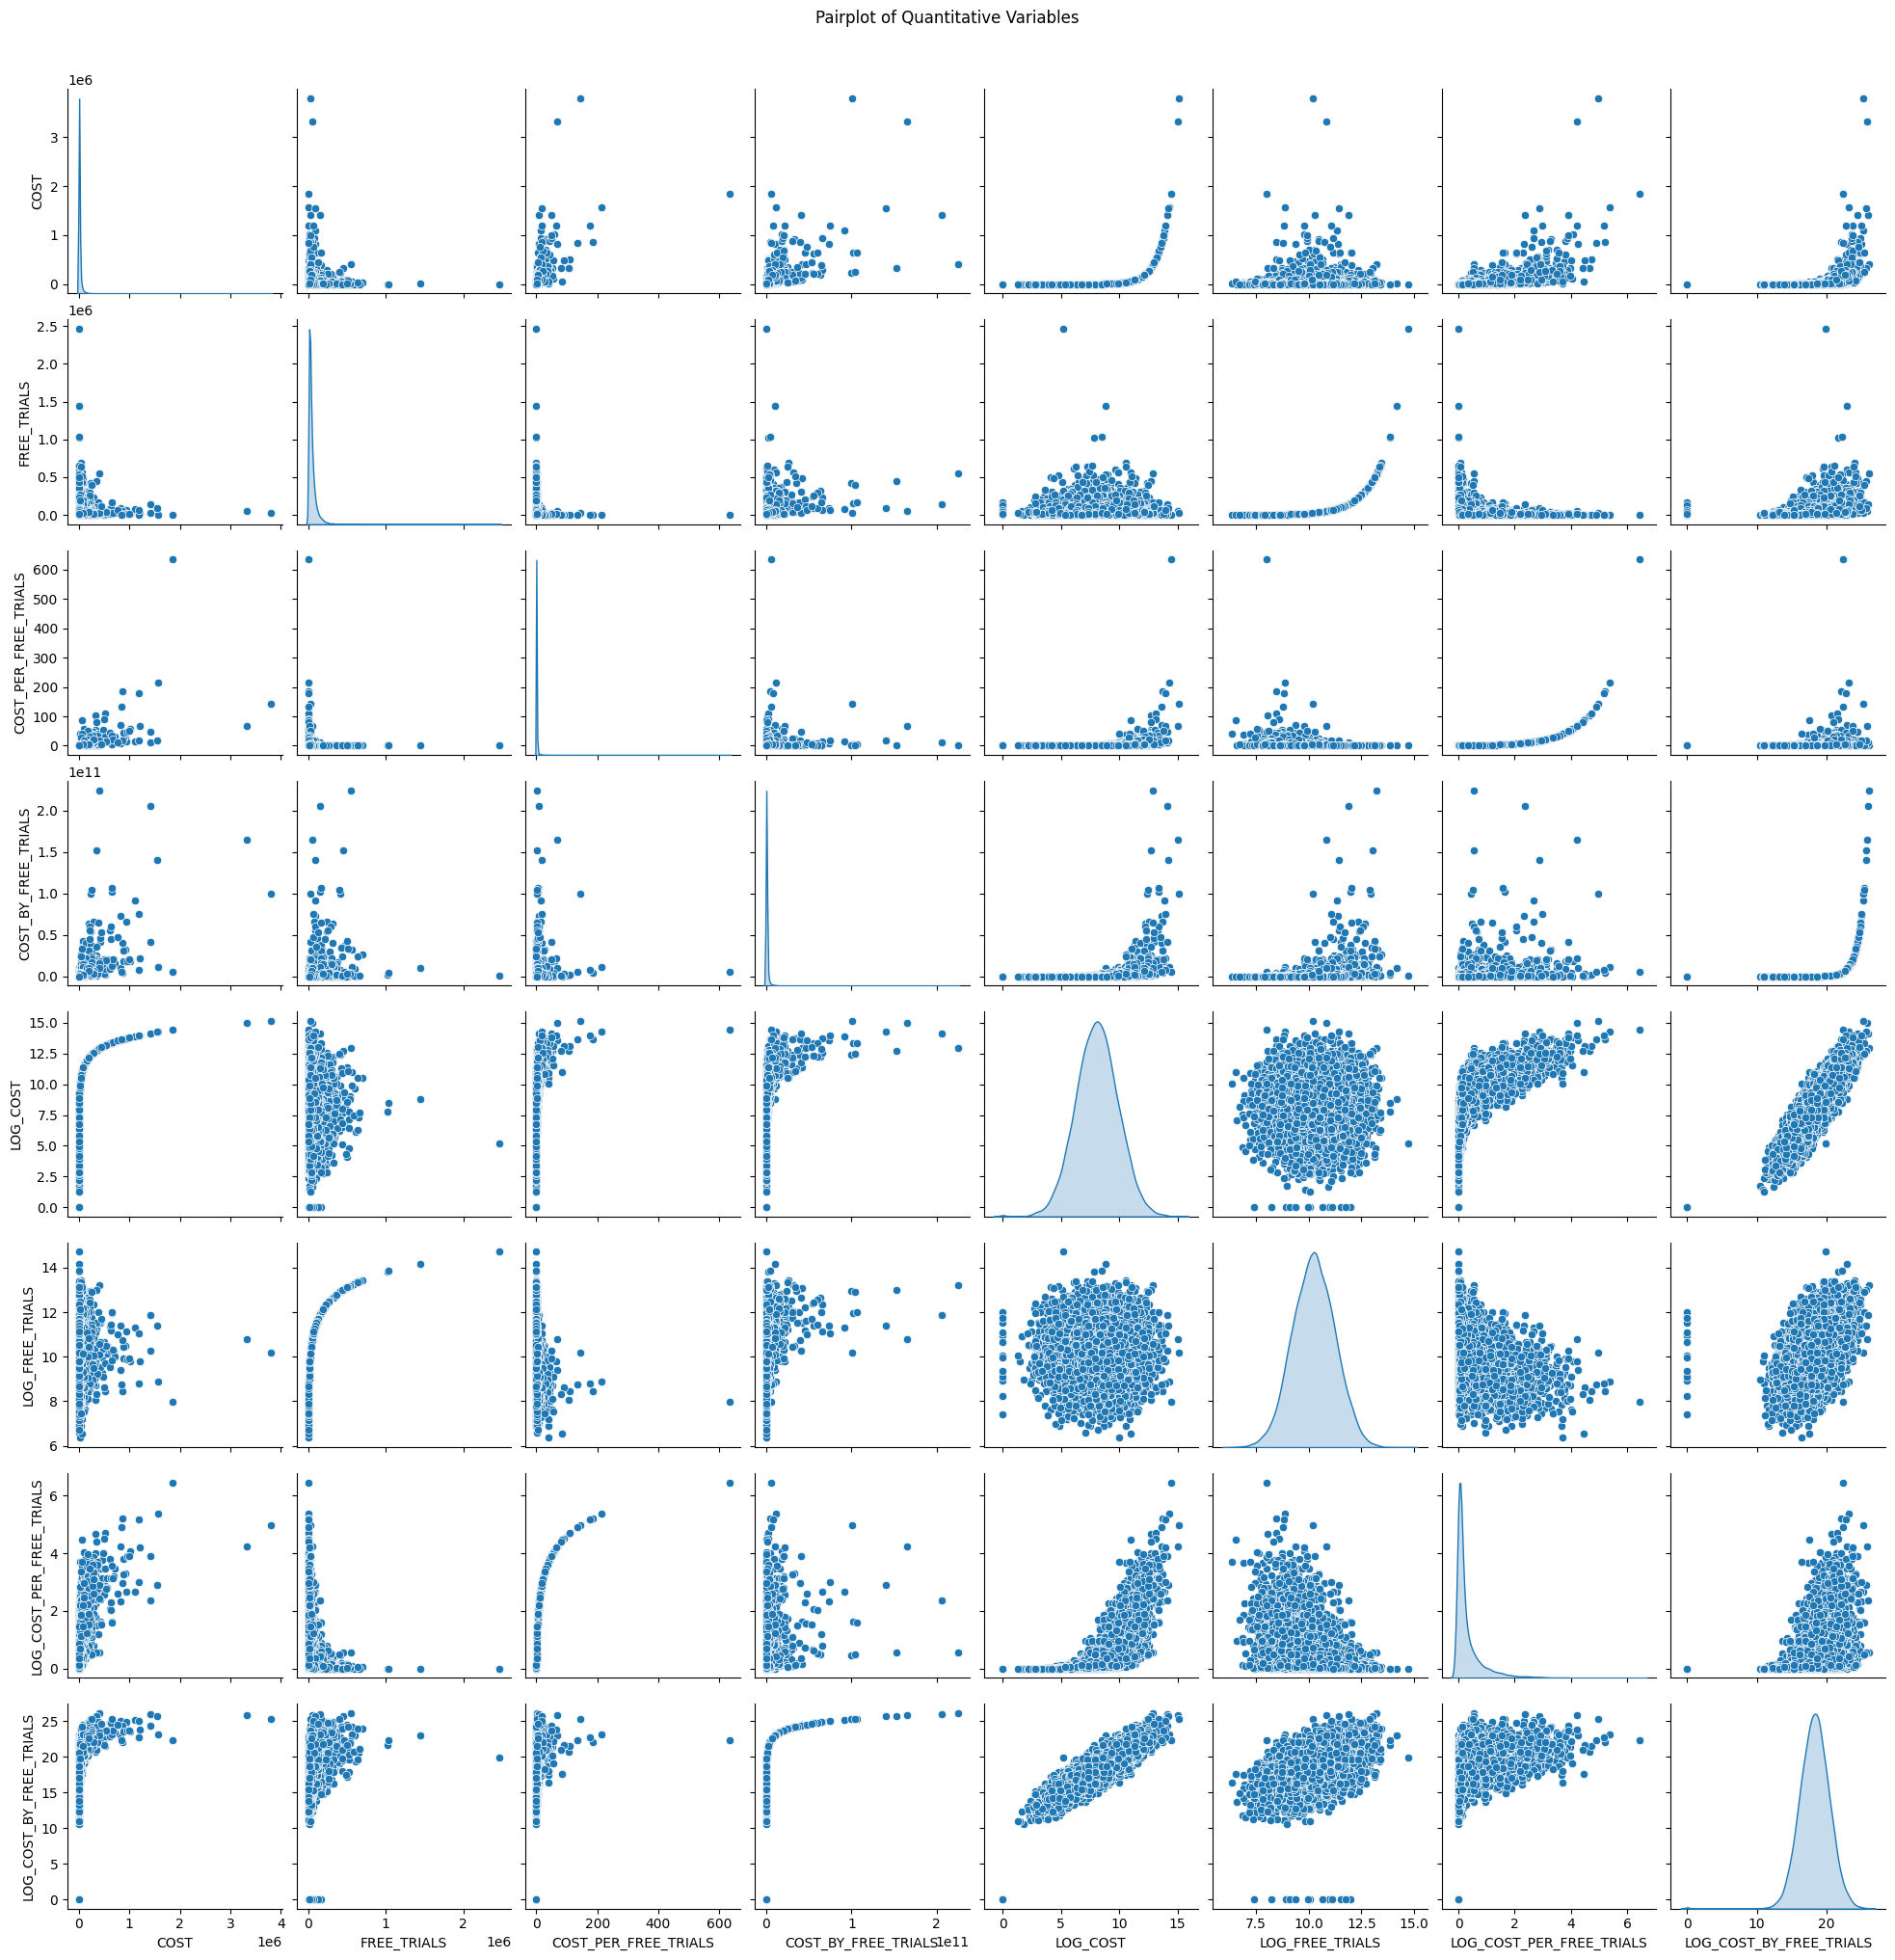

In [11]:
'''
Covariation Analysis using Scatterplot:

1. LOG_COST and LOG_FREE_TRIALS doesn't show a strong linear relationship. There is some positive relationship but we also see diminishing
returns and/or increasing likelihood of a campaign not generating a typical "linearly" free trial count aka risk. Likewise, we see a bunch of campaigns
that had minimal costs and yet generated a lot of free trials. This could be really efficent campaign strategy or incorrect data misrepresentation.
Regardless, somewaht a linear relationship with diminishing returns past a cost threshold.

2. We see a a lot of non-linear relationships. We can either perform more feature enginering like square root or taking the polynomial or we can use a model to capture
relationships beyond linearaity. Overall, no strong evidence of any visuls with any indication of any linear relationship.

3. For campaigns that require minimal cost, there's a wide spread of LOG_COST_PER_FREE_TRIALS signalying high variability in efficiency at lower spending levels. This could be
the "gold standard" comapnies that are succesfull in buidling their brand/lyoalty and customer base and leveraging that to generate free trials at a high efficeint clip (high efficeny).
This is a "sweet spot" because even for campaigns that generated minimal free trials, at least your cost was small too. Therefore, less risk is associated while low cost and can have high
ROI while increasing cost on a campaign drastically increases risk of low free trail genreated.

=>. Action Items:
    a. Add cateogircal data to the scatterplot to see if there are any relationships between the two. - DONE
    b. Filter data on 0's in 'LOG_COST' for more analysis. - DONE
    c. Filter data on high 'LOG_COST' with low 'LOG_FREE TRIALS' for more analysis.
    d. Filter data on low 'LOG_COST' and high 'LOG_FREE TRIALS' for more analysis.
'''
totalColumns = set(df.columns)
totalColumns.remove('REPORT_DATE')

# quantitative=list(set(totalColumns) - set(categorical))
# quantitative
logs = [f'LOG_{quant_name}' for quant_name in quantitative]
quantitative.extend(logs)
#LOG_COST_PER_FREE_TRIALS	LOG_COST_BY_FREE_TRIALS
sns.pairplot(df[quantitative], diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Quantitative Variables', y=1.02)  # Title for the entire plot
plt.show()

In [12]:
data_hashmap = categorize_columns(df)
data_hashmap

{'categorical': ['ATL_OR_DR',
  'CAMPAIGN_TYPE',
  'CHANNEL',
  'HOLIDAY_FLAG',
  'MONTH',
  'ATL_OR_DR_CAMPAIGN_TYPE',
  'ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL',
  'ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL_MONTH',
  'ATL_OR_DR_CAMPAIGN_TYPE_MONTH',
  'ATL_OR_DR_CHANNEL',
  'ATL_OR_DR_CHANNEL_MONTH',
  'ATL_OR_DR_MONTH',
  'CAMPAIGN_TYPE_CHANNEL',
  'CAMPAIGN_TYPE_CHANNEL_MONTH',
  'CAMPAIGN_TYPE_MONTH',
  'CHANNEL_MONTH'],
 'numerical': ['COST',
  'FREE_TRIALS',
  'COST_PER_FREE_TRIALS',
  'COST_BY_FREE_TRIALS',
  'LOG_COST',
  'LOG_FREE_TRIALS',
  'LOG_COST_PER_FREE_TRIALS',
  'LOG_COST_BY_FREE_TRIALS'],
 'miscellaneous': ['REPORT_DATE']}

In [13]:
# data_hashmap['categorical']= ['ATL_OR_DR',
#   'CAMPAIGN_TYPE',
#   'CHANNEL',
#   'HOLIDAY_FLAG',
#   'MONTH','ATL_OR_DR_CHANNEL','CAMPAIGN_TYPE_CHANNEL']

In [14]:
# data_hashmap['numerical']

In [56]:
df

REPORT_DATE             ATL_OR_DR CAMPAIGN_TYPE      CHANNEL       COST  \
0      2023-06-09  DR - Direct Response         Title  paid social    7784.31   
1      2023-08-29  DR - Direct Response         Title          app    2474.31   
2      2023-07-23  ATL - Above The Line         Title  paid social   10222.82   
3      2023-12-23  DR - Direct Response         Title          app   49631.87   
4      2022-08-31  ATL - Above The Line         Title  paid social    2081.06   
...           ...                   ...           ...          ...        ...   
14103  2024-02-23  ATL - Above The Line         Brand         bvod    1478.78   
14104  2024-04-21  ATL - Above The Line         Title          ooh     839.25   
14105  2023-12-13  ATL - Above The Line         Title         bvod  193796.71   
14106  2023-02-04  ATL - Above The Line         Brand  paid social   84690.65   
14107  2023-02-17  DR - Direct Response         Title      youtube    7385.46   

       FREE_TRIALS  HOLIDAY_FLAG     MONTH     ATL_OR_DR_CAMPAIGN_TYPE  \
0         86401.15         False      June  DR - Direct Response_Title   
1          2956.74         False    August  DR - Direct Response_Title   
2         12513.08         False      July  ATL - Above The Line_Title   
3         17207.04          True  December  DR - Direct Response_Title   
4         21758.33         False    August  ATL - Above The Line_Title   
...            ...           ...       ...                         ...   
14103     16941.67         False  February  ATL - Above The Line_Brand   
14104      5727.03         False     April  ATL - Above The Line_Title   
14105     34824.51         False  December  ATL - Above The Line_Title   
14106     25140.77         False  February  ATL - Above The Line_Brand   
14107     17770.26         False  February  DR - Direct Response_Title   

              ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL  ... CAMPAIGN_TYPE_CHANNEL  \
0      DR - Direct Response_Title_paid social  ...     Title_paid social   
1              DR - Direct Response_Title_app  ...             Title_app   
2      ATL - Above The Line_Title_paid social  ...     Title_paid social   
3              DR - Direct Response_Title_app  ...             Title_app   
4      ATL - Above The Line_Title_paid social  ...     Title_paid social   
...                                       ...  ...                   ...   
14103         ATL - Above The Line_Brand_bvod  ...            Brand_bvod   
14104          ATL - Above The Line_Title_ooh  ...             Title_ooh   
14105         ATL - Above The Line_Title_bvod  ...            Title_bvod   
14106  ATL - Above The Line_Brand_paid social  ...     Brand_paid social   
14107      DR - Direct Response_Title_youtube  ...         Title_youtube   

      CAMPAIGN_TYPE_CHANNEL_MONTH CAMPAIGN_TYPE_MONTH         CHANNEL_MONTH  \
0          Title_paid social_June          Title_June      paid social_June   
1                Title_app_August        Title_August            app_August   
2          Title_paid social_July          Title_July      paid social_July   
3              Title_app_December      Title_December          app_December   
4        Title_paid social_August        Title_August    paid social_August   
...                           ...                 ...                   ...   
14103         Brand_bvod_February      Brand_February         bvod_February   
14104             Title_ooh_April         Title_April             ooh_April   
14105         Title_bvod_December      Title_December         bvod_December   
14106  Brand_paid social_February      Brand_February  paid social_February   
14107      Title_youtube_February      Title_February      youtube_February   

      COST_PER_FREE_TRIALS COST_BY_FREE_TRIALS   LOG_COST LOG_FREE_TRIALS  \
0                 0.090095        6.725733e+08   8.959994       11.366768   
1                 0.836837        7.315891e+06   7.814121        7.992181   
2                 0.816971        1.279190e+08   9.

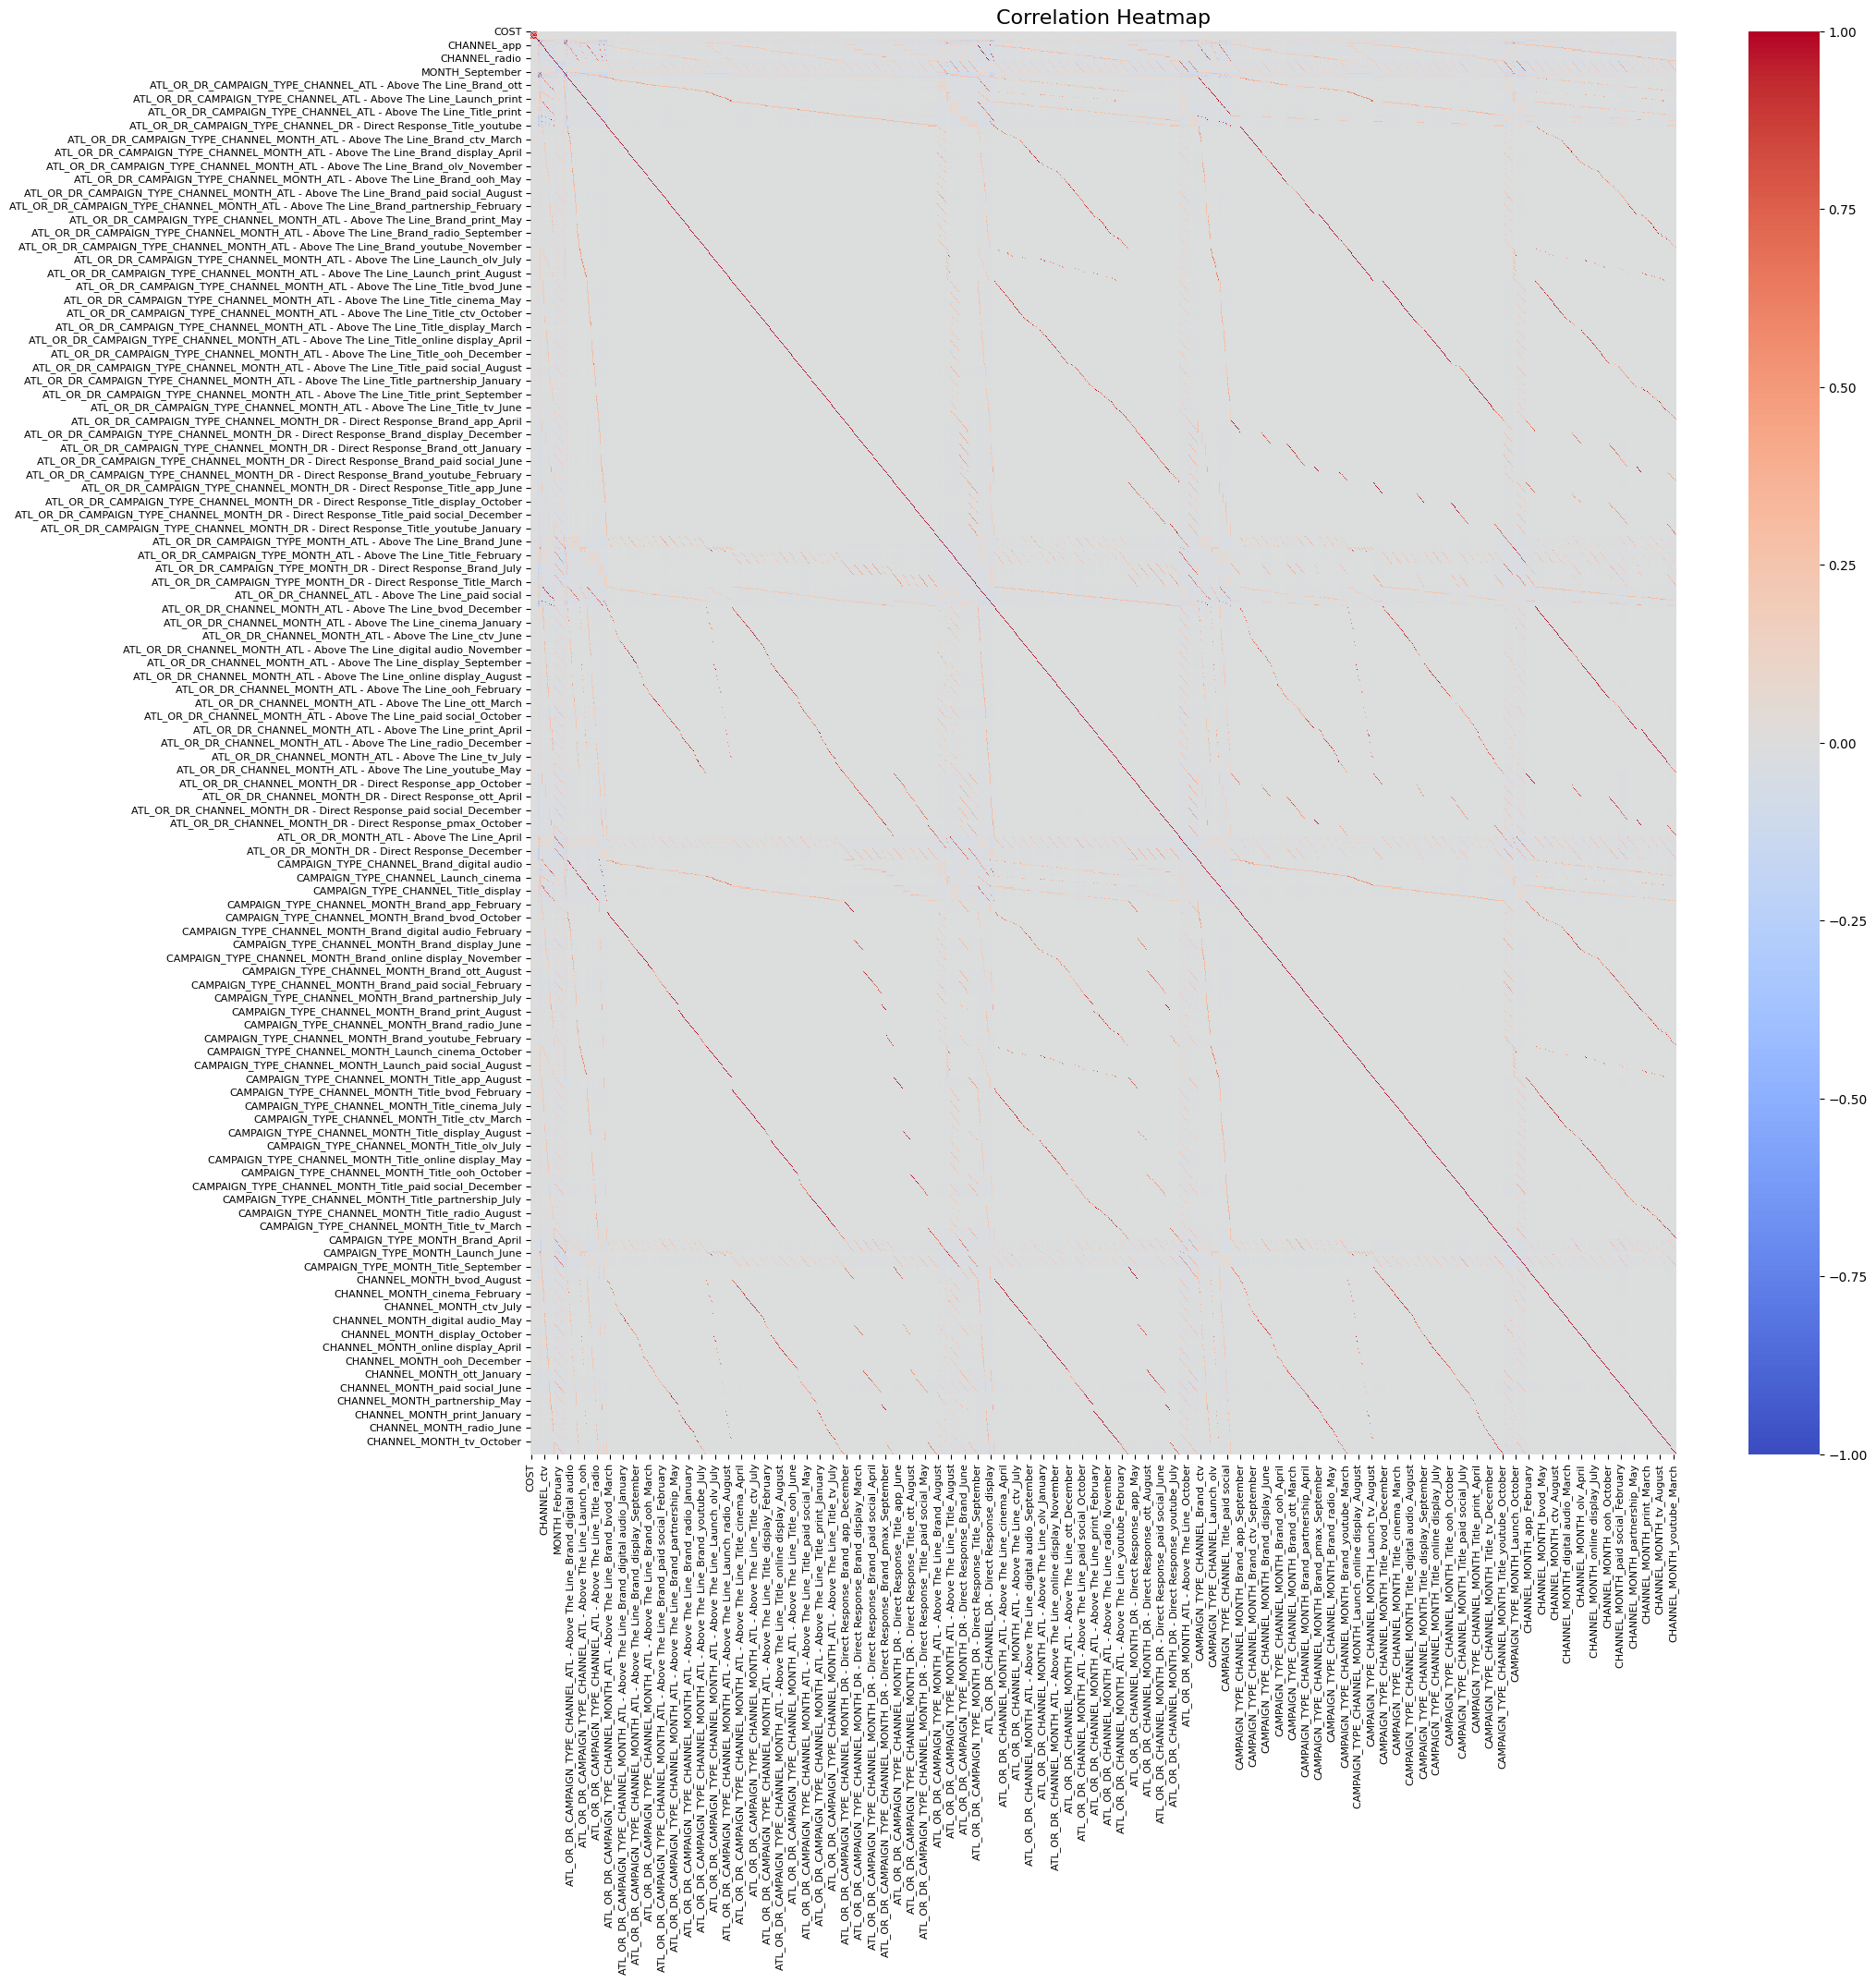

In [15]:
'''
Pearson Correlation using Heatmap

1. Most relationships show weak linaer relationships which is validated in the scatterplot. Since we are predicting FREE_TRIALS,
the heatmap indicates that using a linear model might not be the most effective model to use.

2. Some hot spots are misleading bc they are dervied from feature engineering from previous steps.
'''
# data_hashmap = categorize_columns(df)
# data_hashmap

encoded_df = pd.get_dummies(df[data_hashmap['categorical']], drop_first=False)  # Drop first to avoid multicollinearity
# label_encoded_df = df[data_hashmap['categorical']].apply(LabelEncoder().fit_transform)

# Combine encoded variables with quantitative columns
matrix_df = pd.concat([df[data_hashmap['numerical']], encoded_df], axis=1)
plt.figure(figsize=(20, 20))
sns.heatmap(matrix_df.corr(method='spearman'), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)
plt.show()

# matrix_df = pd.concat([df[data_hashmap['numerical']], encoded_df], axis=1)
# sns.heatmap(matrix_df.corr(), annot=True, cmap="coolwarm", annot_kws={"size": 5})
# plt.xticks(fontsize=6, rotation=90)
# plt.yticks(fontsize=6)

In [55]:
# Inspect Correlation Matrix Before applying filters, check the full correlation matrix:
# print(matrix_df.corr)


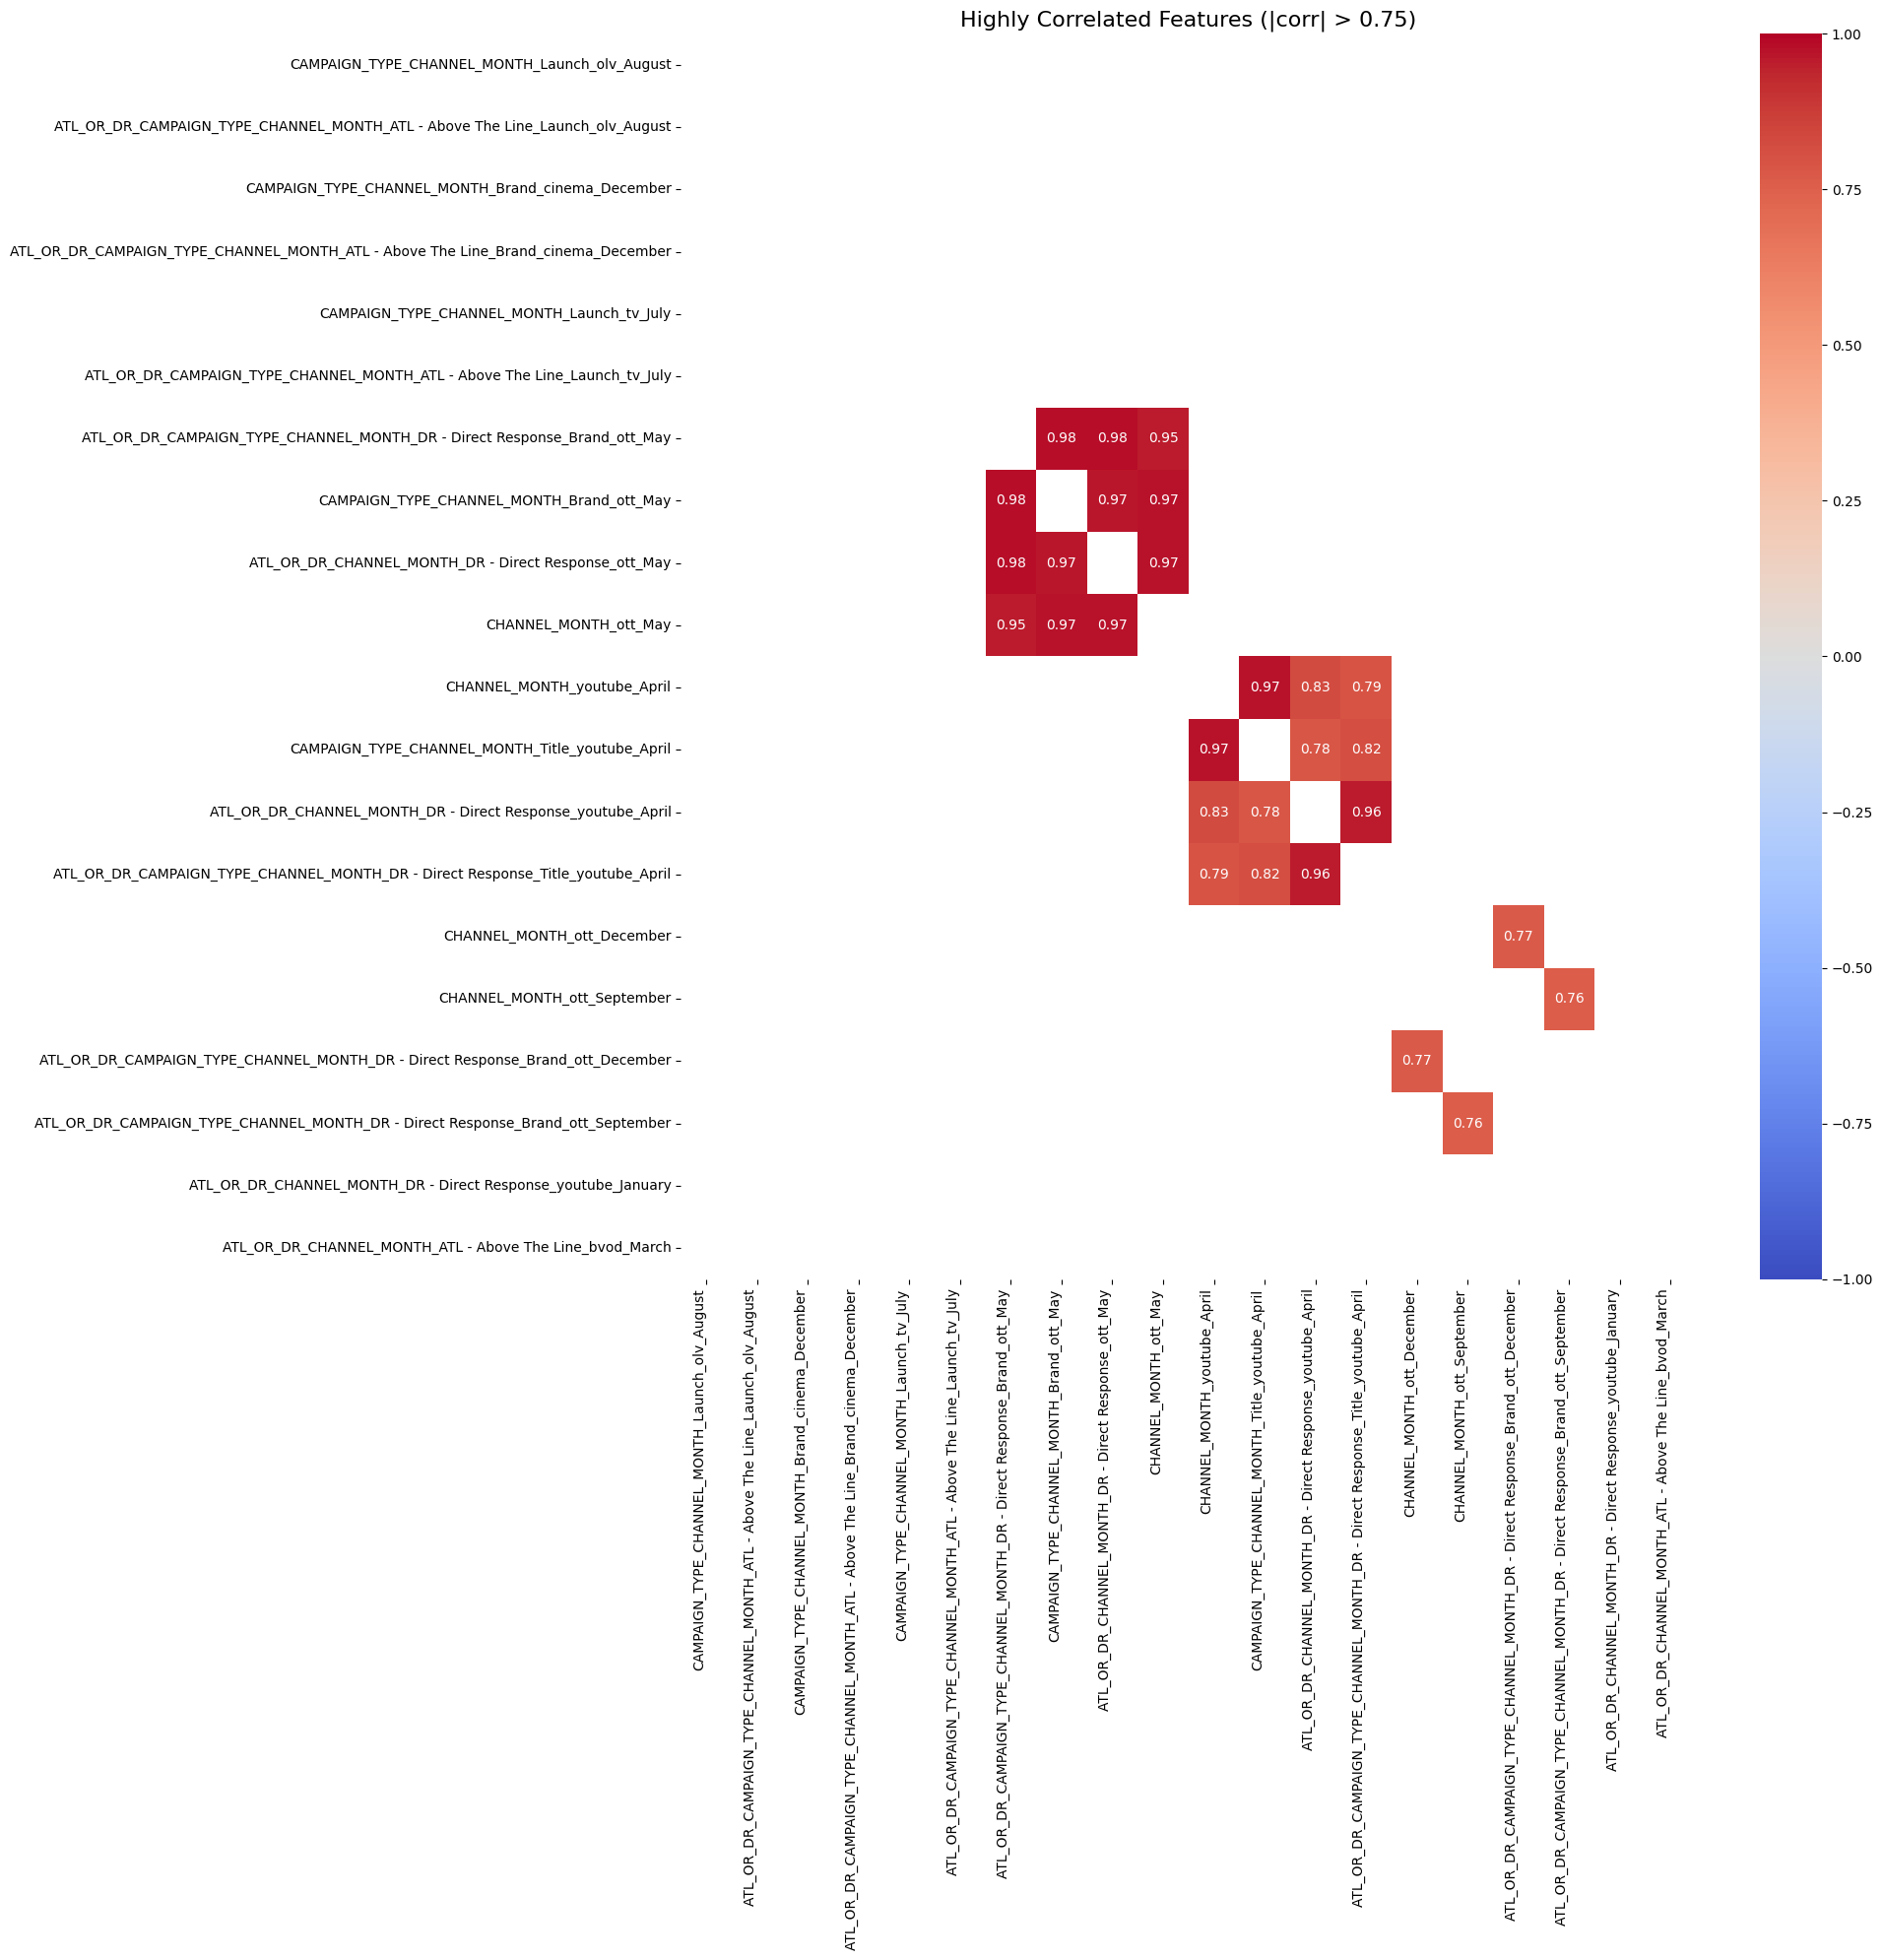

In [49]:
# Calculate correlation matrix
corr = matrix_df.corr()

# Apply stricter filtering
threshold = 0.75
filtered_corr = corr.where((corr.abs() > threshold) & (corr != 1.0))

# Drop rows/columns that are entirely NaN
filtered_corr = filtered_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)


top_features = filtered_corr.abs().sum().sort_values(ascending=False).index[:20]
reduced_corr = filtered_corr.loc[top_features, top_features]
# Check if filtered_corr is empty
if filtered_corr.empty:
    print("No correlations found above the threshold.")
else:
    # Dynamically adjust plot size with robust logic
    # figsize = (max(10, min(len(reduced_corr) * 0.5, 30)),
    #            max(10, min(len(reduced_corr) * 0.5, 30)))

    # Plot the heatmap
    plt.figure(figsize=(20,20))
    #sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, cbar=True)
    sns.heatmap(
    reduced_corr,
    annot=True, #reduced_corr.abs() > 0.85,  # Annotate strong correlations only
    fmt=".2f",  # Format annotations
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    cbar=True,
)
    plt.title(f"Highly Correlated Features (|corr| > {threshold})", fontsize=16)
    plt.xticks(fontsize=10, rotation=90, ha='right')
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


In [18]:
# Inspect Filtered Correlation Check the shape of filtered_corr after filtering:
print(filtered_corr.shape)
print(filtered_corr)


(625, 625)
                                 LOG_COST  LOG_COST_BY_FREE_TRIALS  \
LOG_COST                              NaN                 0.873499   
LOG_COST_BY_FREE_TRIALS          0.873499                      NaN   
ATL_OR_DR_ATL - Above The Line        NaN                      NaN   
ATL_OR_DR_DR - Direct Response        NaN                      NaN   
CAMPAIGN_TYPE_Brand                   NaN                      NaN   
...                                   ...                      ...   
CHANNEL_MONTH_youtube_June            NaN                      NaN   
CHANNEL_MONTH_youtube_March           NaN                      NaN   
CHANNEL_MONTH_youtube_November        NaN                      NaN   
CHANNEL_MONTH_youtube_October         NaN                      NaN   
CHANNEL_MONTH_youtube_September       NaN                      NaN   

                                 ATL_OR_DR_ATL - Above The Line  \
LOG_COST                                                    NaN   
LOG_COST_BY_FR

In [19]:
# from scipy.cluster.hierarchy import linkage, dendrogram
# import seaborn as sns

# corr = matrix_df.corr()
# linkage_matrix = linkage(corr, method='ward')

# sns.clustermap(
#     corr,
#     cmap="coolwarm",
#     linewidths=0.5,
#     figsize=(15, 15),
#     annot=False,
#     row_cluster=True,
#     col_cluster=True,
# )


### Univariate Analysis on Categorical Data

In [20]:
# new_cats = list(totalColumns - set(quantitative))
# categorical = (new_cats)
# categorical

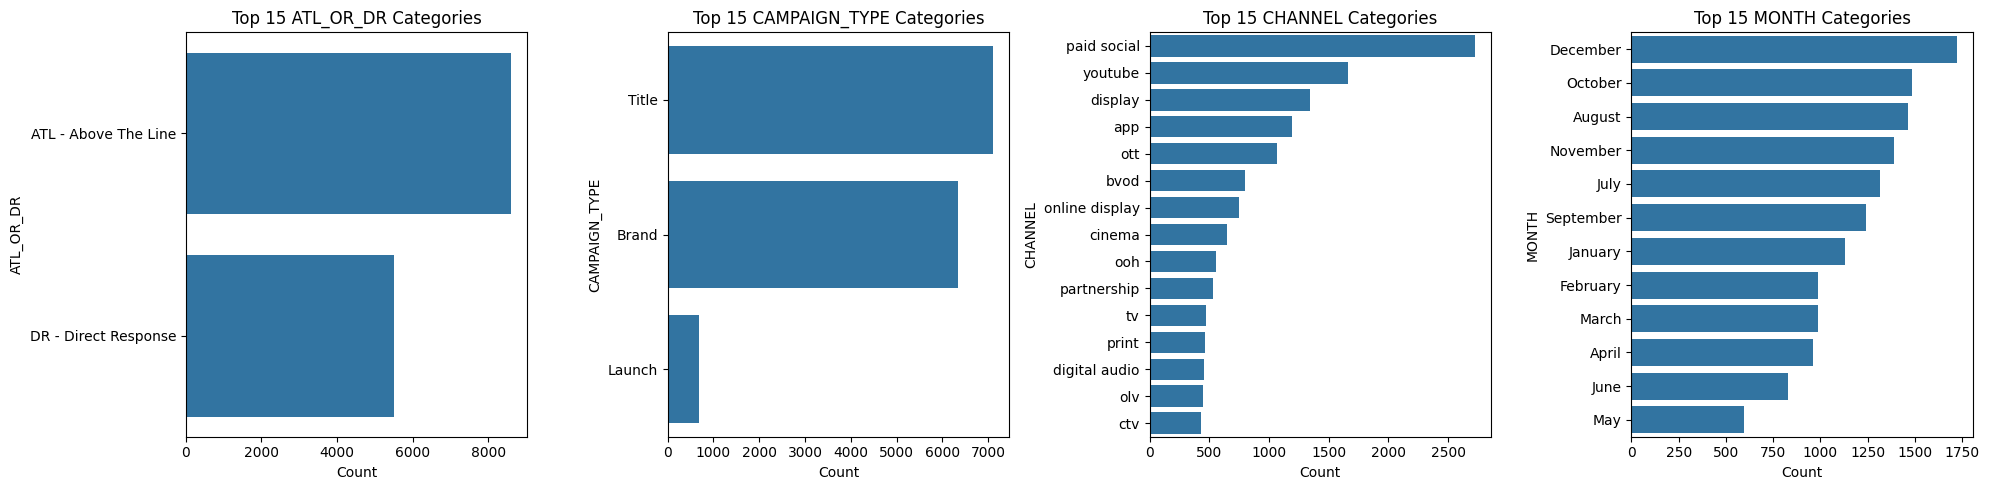

In [21]:
'''
Single Variation Categorical Analysis using Barchart:

1. ATL is a more popular type of campaign over DR. This aligns with your typical business marketing lifecycle where
companies/customers continuosly build and reinforce their brand over time. This is also apparent in the campaign types:
title and brand are more popular while launch campaigns are less frequent. This could also relate to the fact that there
is a high barriers of entry for launching new products or entering new market regions associated with cost. Promotional
campaigns do not exist.

2. Paid Social and other digitial media devices are the most popular over your traditional media devices like TV, radio, and print.
This isn't to infer that these traditional media devices are not effective, but rather the shift in the digital age. Reduce
spending on traditional media devices and reallocating resources to digital media devices could be a good strategy but you might
lose out on niche customers/target audience that can only be reached a certain way.

3. Fall/Winter show the highest number of campaigns being aired. This could be companies/customers wanting to capitalize on the
holiday season. Specifically December shows the highest number of campaigns being aired followed by October and November(Black Friday/
Cyber Monday?)

=> Action Items:
    a. Covariation Analysis between Categorical & Continuous' using Scatterplot and hue
    b. Covariation Analysis between categorical and continuous using boxplot and barcharts
'''

top_n = 15  # Define the top N categories to display

# Calculate the number of rows and columns dynamically based on the number of categorical variables
num_cols = len(categorical)
ncols = 4  # Number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Dynamically adjust rows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# Flatten axes for iteration
axes = axes.flatten()

# Plot horizontal bar plots for each categorical variable
for i, cat in enumerate(categorical):
    # Get the top N categories and their counts
    top_categories = df[cat].value_counts().head(top_n)
    sns.barplot(y=top_categories.index, x=top_categories.values, ax=axes[i])

    # Customize each subplot
    axes[i].set_title(f'Top {top_n} {cat} Categories')
    axes[i].set_ylabel(cat)
    axes[i].set_xlabel('Count')
    axes[i].tick_params(axis='y', rotation=0)  # Keep y-axis labels horizontal for readability

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# num_cols = len(categorical)
# ncols = 4  # Number of columns per row
# nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Dynamically adjust rows
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# # Flatten axes for iteration
# axes = axes.flatten()

# # Plot bar plots for each categorical variable
# for i, cat in enumerate(categorical):
#     sns.countplot(x=cat, data=df, ax=axes[i])
#     axes[i].set_title(f'Bar plot of {cat}')
#     axes[i].set_xlabel(cat)
#     axes[i].set_ylabel('Count')
#     axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# # Remove unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()


### Multivariate Analysis

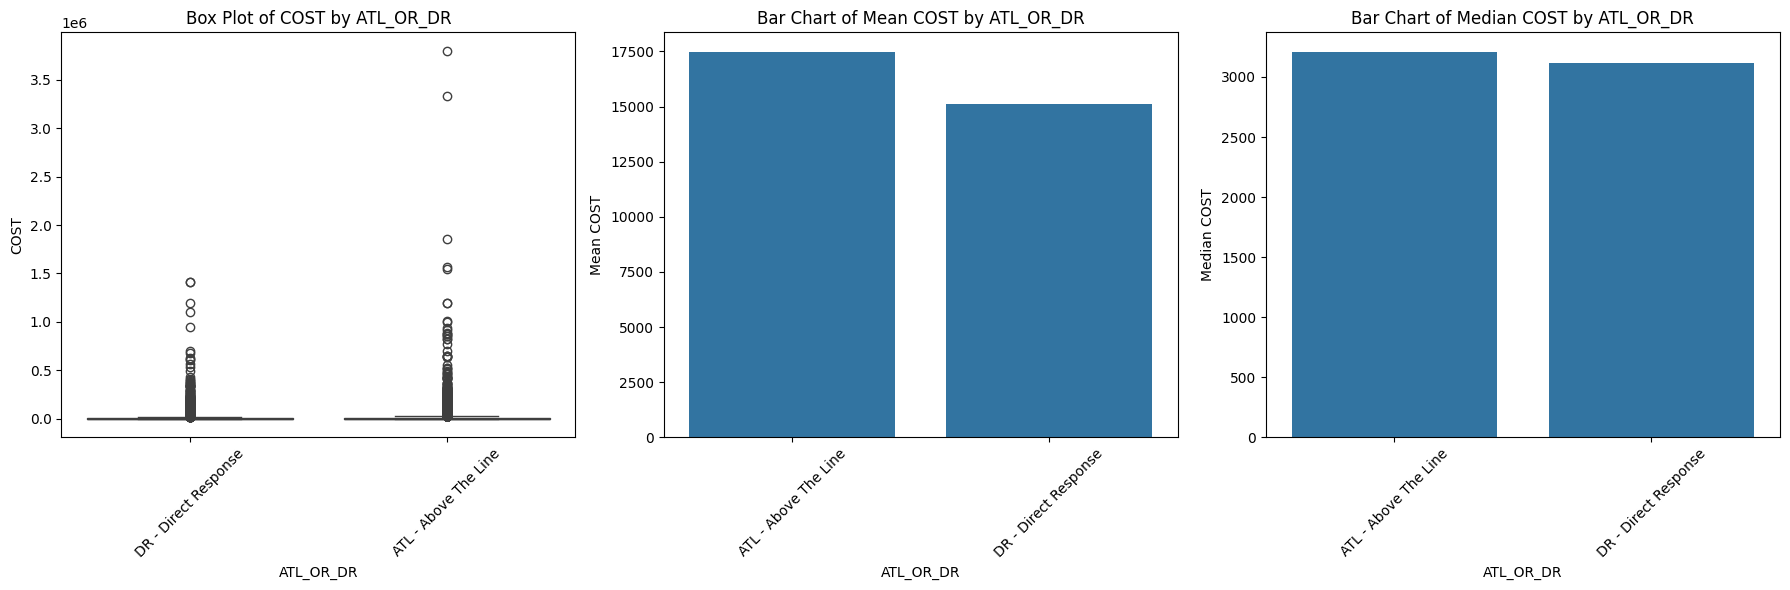

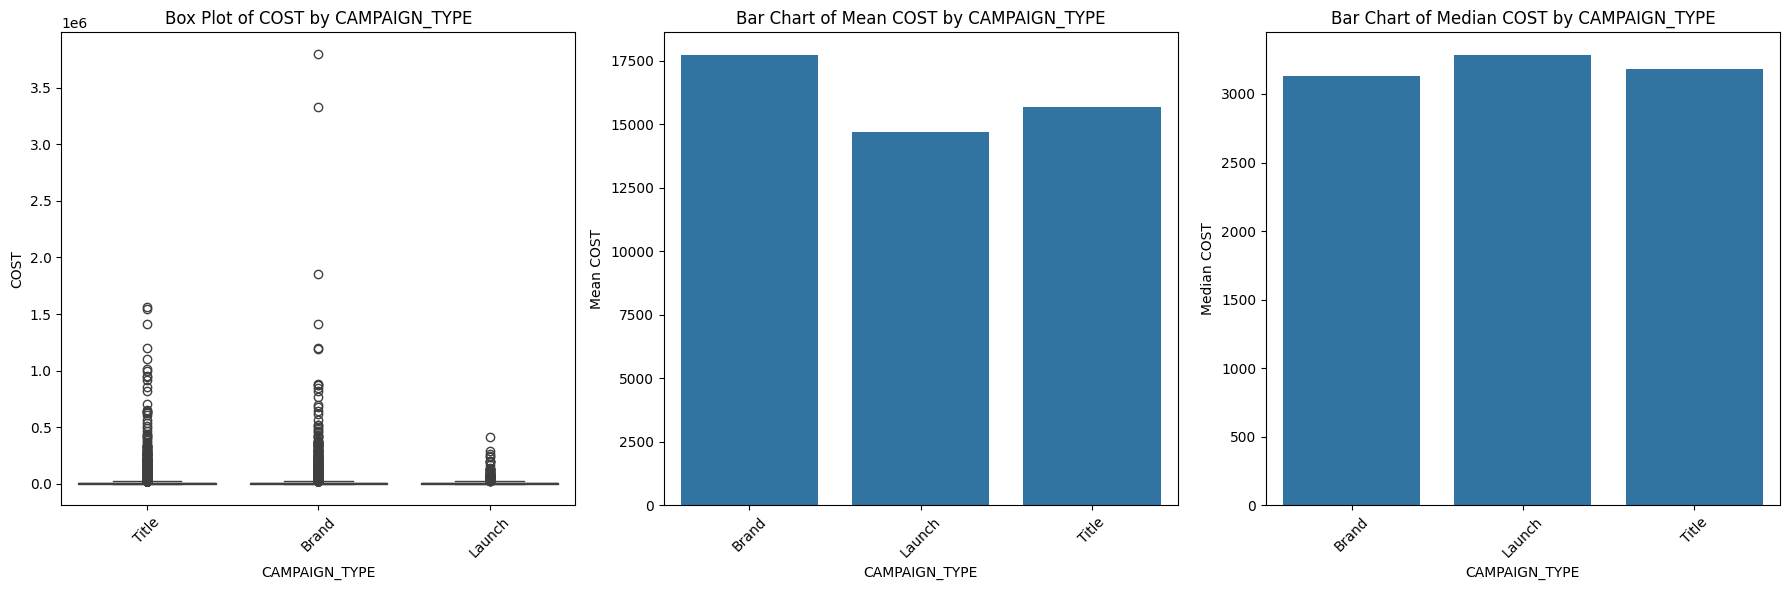

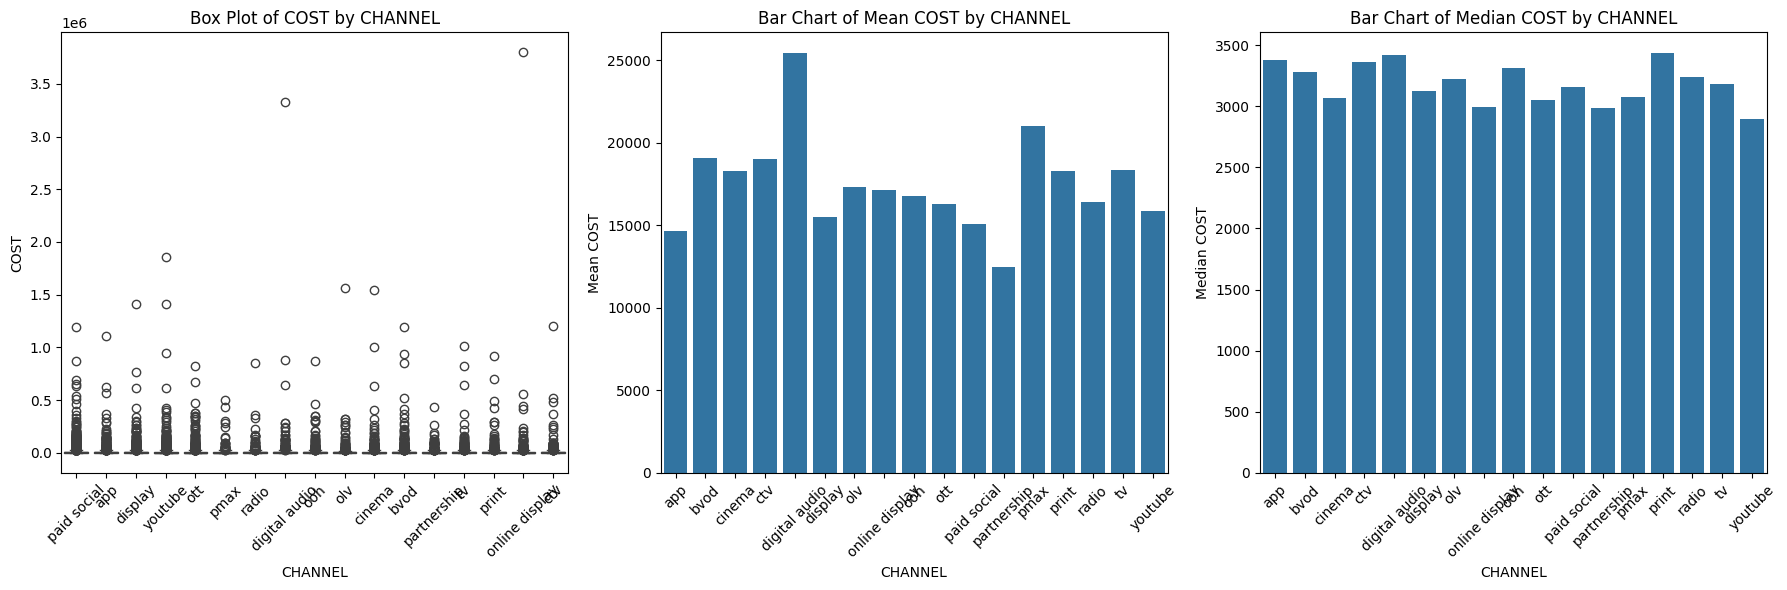

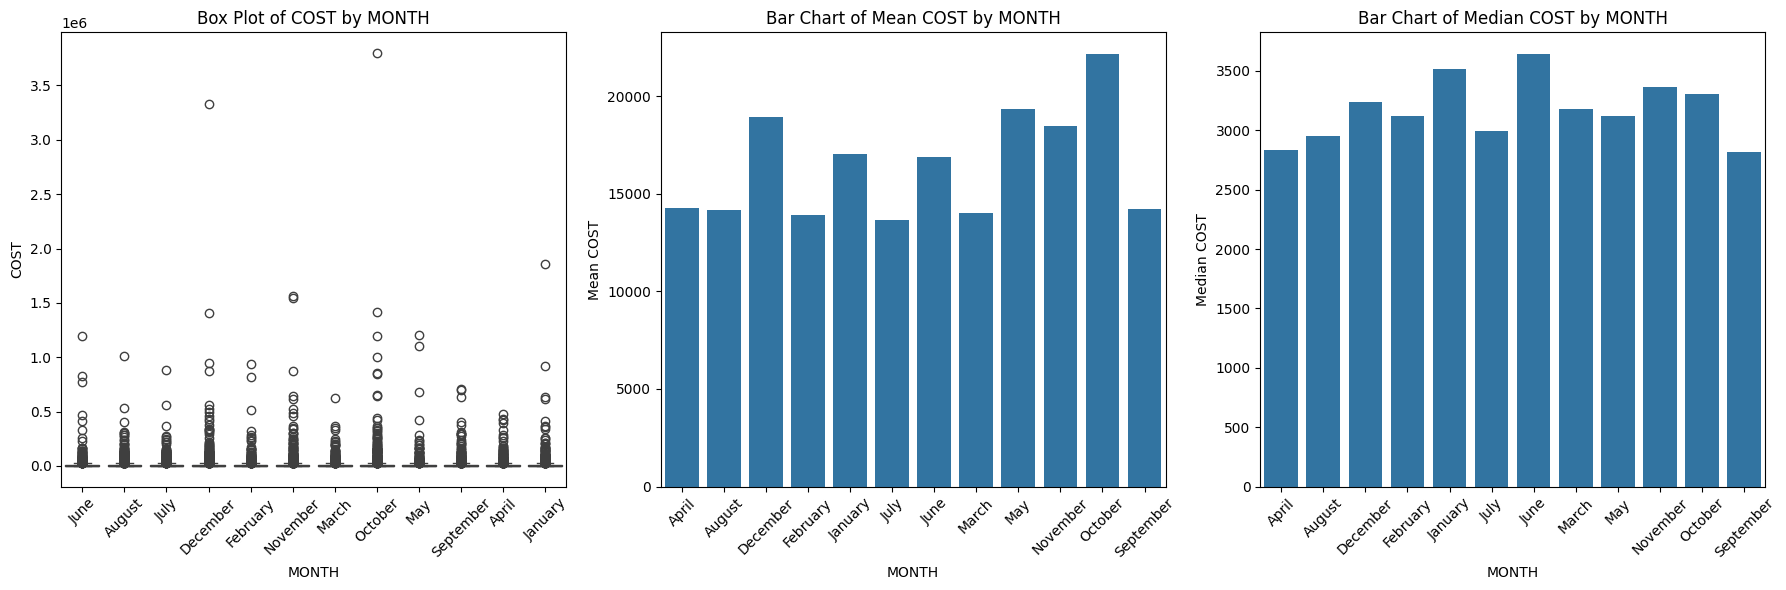

In [22]:
'''
Covariation Analysis between Categorical & Continuous using boxplot and barcharts:

1. ATL tend to have a slight higher cost associated with it than DR.

2. Different channels have a higher/lower cost associated with running a campaign. This
could be one of the driving factors in campaign strategies.

3. It cost more to run on holidays than non-holidays. This can be an area of opportunity
to see if spending more money to run on holidays is worth it or not regarding free trials
generated.

4. Spring tends to be the cheapest season to run a campaign. Perhaps leeast amount of holidays?

5.
'''
''''''
for category in categorical:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create side-by-side plots

    # Box Plot
    sns.boxplot(x=category, y='COST', data=df, ax=axes[0])
    axes[0].set_title(f'Box Plot of COST by {category}')
    axes[0].set_xlabel(category)
    axes[0].set_ylabel('COST')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart (Mean)
    mean_bar_data = df.groupby(category)['COST'].mean().reset_index()
    sns.barplot(x=category, y='COST', data=mean_bar_data, ax=axes[1])
    axes[1].set_title(f'Bar Chart of Mean COST by {category}')
    axes[1].set_xlabel(category)
    axes[1].set_ylabel('Mean COST')
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart (Median)
    median_bar_data = df.groupby(category)['COST'].median().reset_index()
    sns.barplot(x=category, y='COST', data=median_bar_data, ax=axes[2])
    axes[2].set_title(f'Bar Chart of Median COST by {category}')
    axes[2].set_xlabel(category)
    axes[2].set_ylabel('Median COST')
    axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Adjust layout
    plt.tight_layout()
    plt.show()


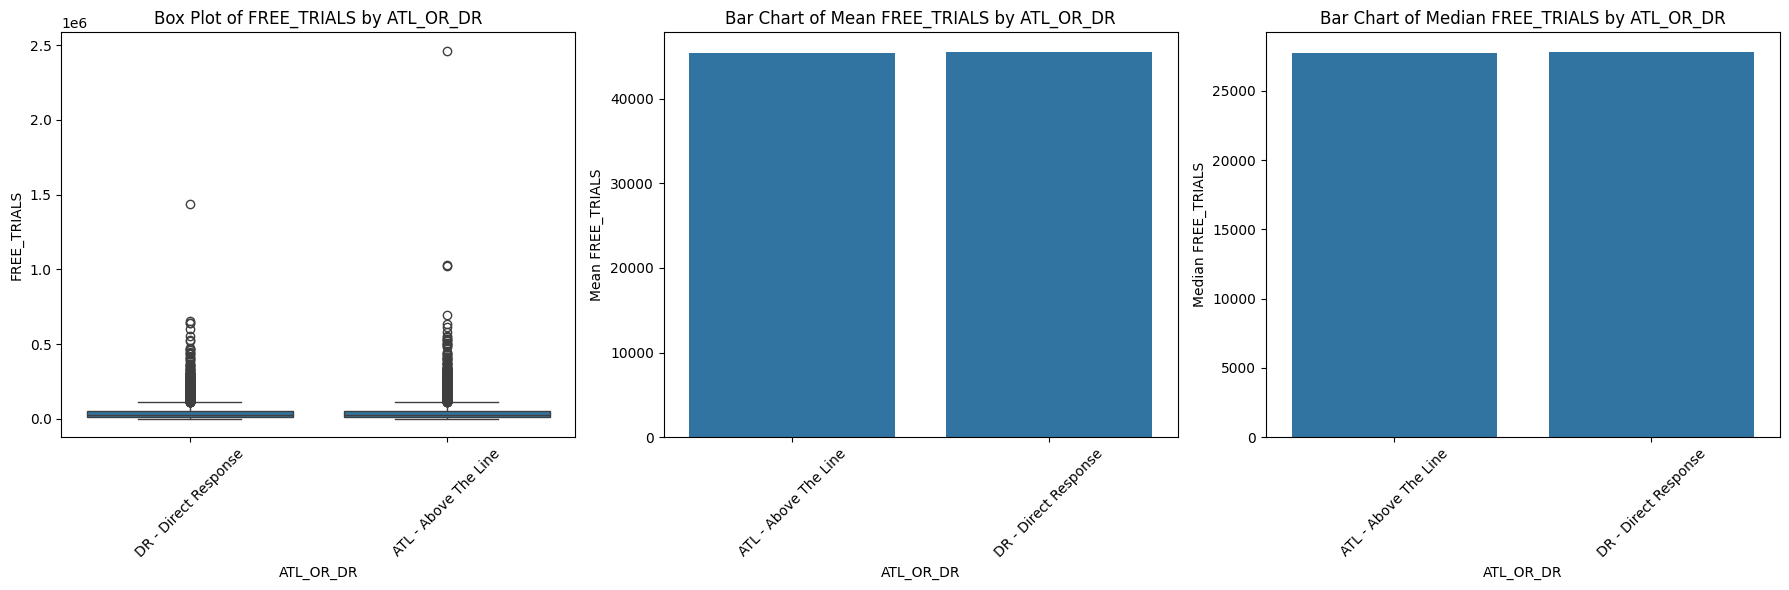

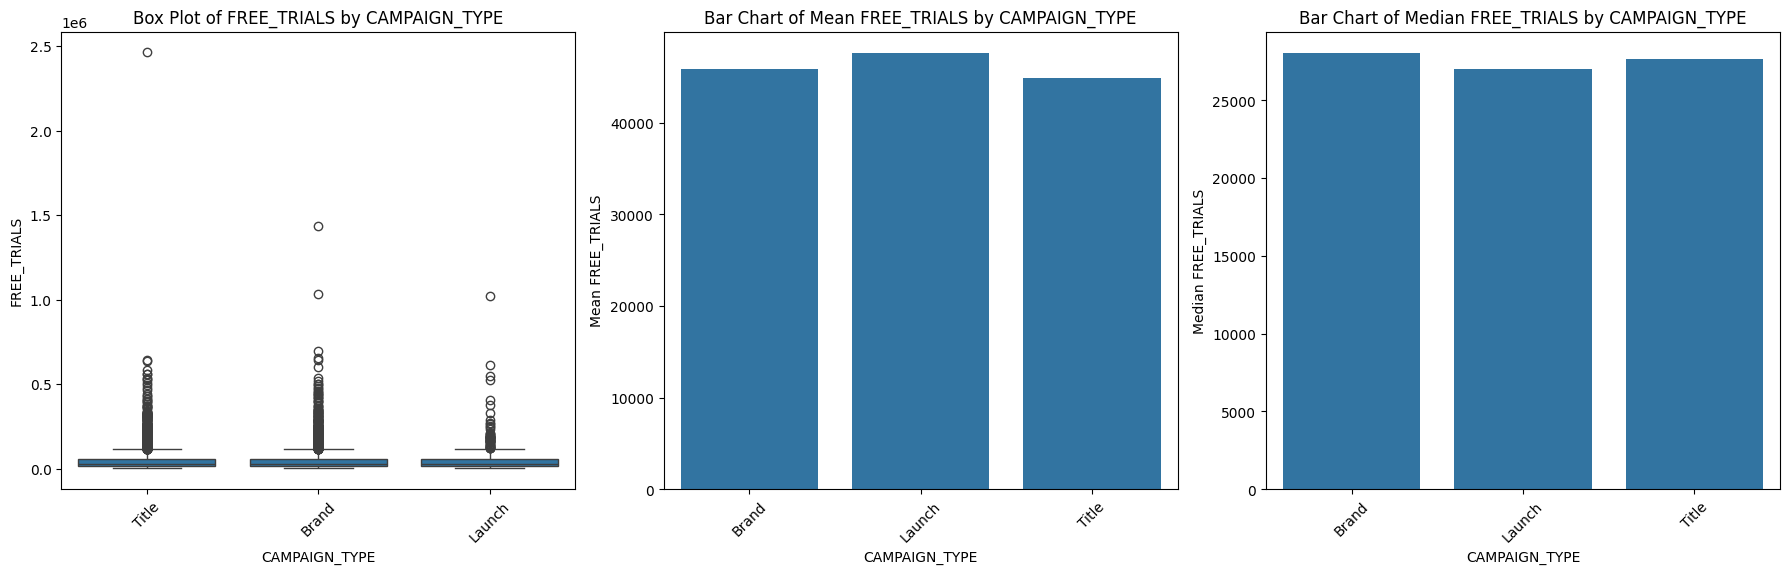

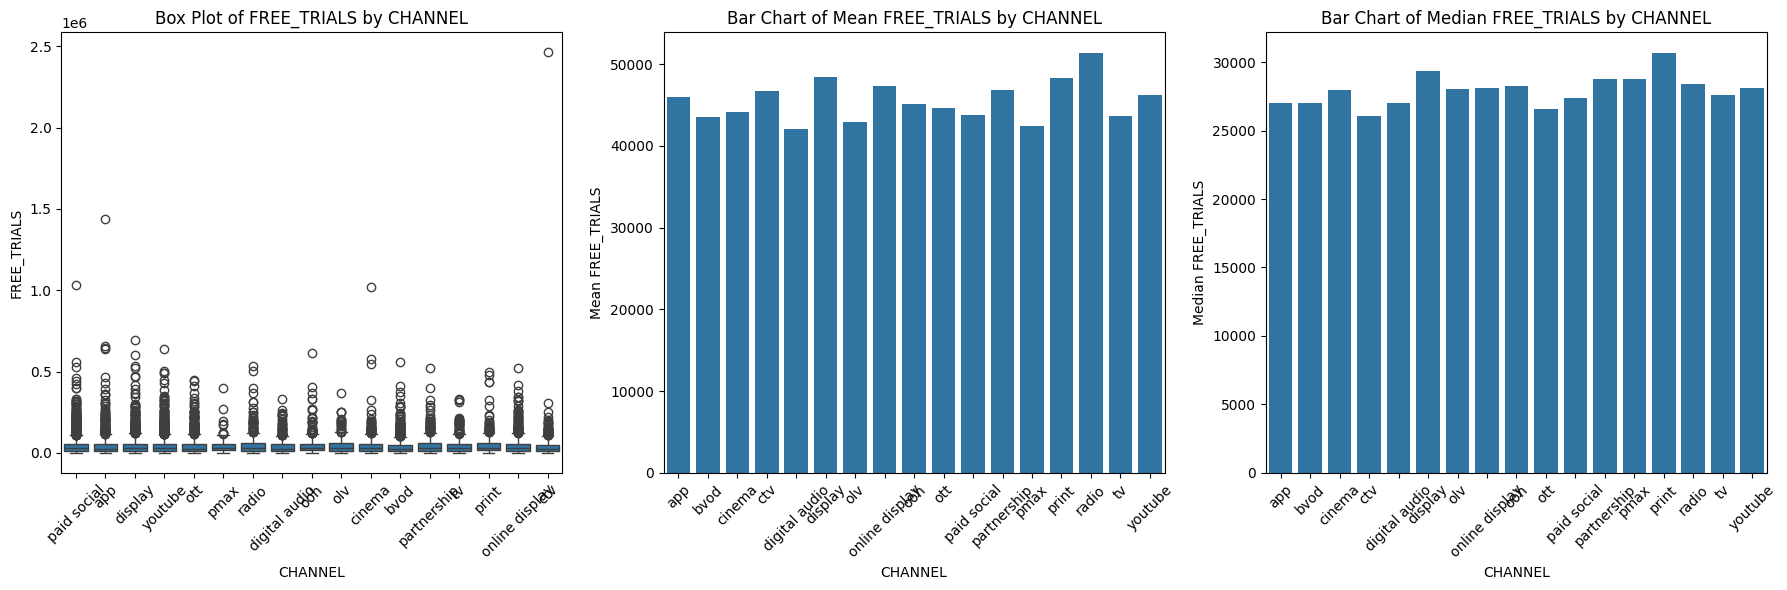

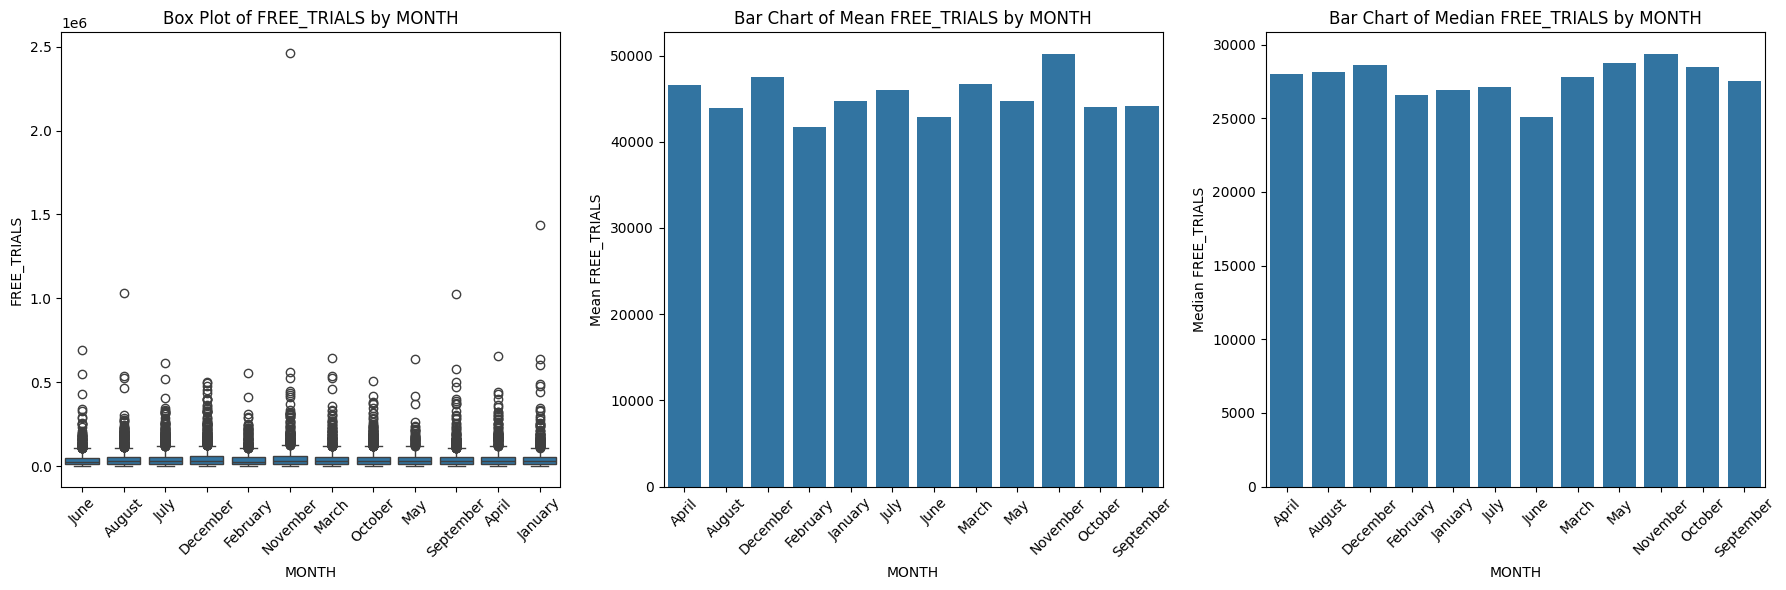

In [23]:
'''
Covariation Analysis between Categorical & Continuous using boxplot and barcharts:

1. ATL/DR doesn't show much of a difference in free trials generated despite ATL/DR being the more
popular choice. CAMPAIGN_TYPE doesn't show much of a difference either.

2. Similarly to cost, different channels have a higher/lower free trials generated. This could be
an influential factor in campaign strategy.

3. Free Trials don't generate higher clicks on holidays than non-holidays. If so, since we know it
cost more to run on holidays, it's better for customers/clients to not run campaigns on holidays.
One factor could be more competition and/or people are spending it with each other.

4. Seasons/months don't show much of a difference in free trials generated.
'''
for category in categorical:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create side-by-side plots

    # Box Plot
    sns.boxplot(x=category, y='FREE_TRIALS', data=df, ax=axes[0])
    axes[0].set_title(f'Box Plot of FREE_TRIALS by {category}')
    axes[0].set_xlabel(category)
    axes[0].set_ylabel('FREE_TRIALS')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart (Mean)
    mean_bar_data = df.groupby(category)['FREE_TRIALS'].mean().reset_index()
    sns.barplot(x=category, y='FREE_TRIALS', data=mean_bar_data, ax=axes[1])
    axes[1].set_title(f'Bar Chart of Mean FREE_TRIALS by {category}')
    axes[1].set_xlabel(category)
    axes[1].set_ylabel('Mean FREE_TRIALS')
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart (Median)
    median_bar_data = df.groupby(category)['FREE_TRIALS'].median().reset_index()
    sns.barplot(x=category, y='FREE_TRIALS', data=median_bar_data, ax=axes[2])
    axes[2].set_title(f'Bar Chart of Median FREE_TRIALS by {category}')
    axes[2].set_xlabel(category)
    axes[2].set_ylabel('Median FREE_TRIALS')
    axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Adjust layout
    plt.tight_layout()
    plt.show()

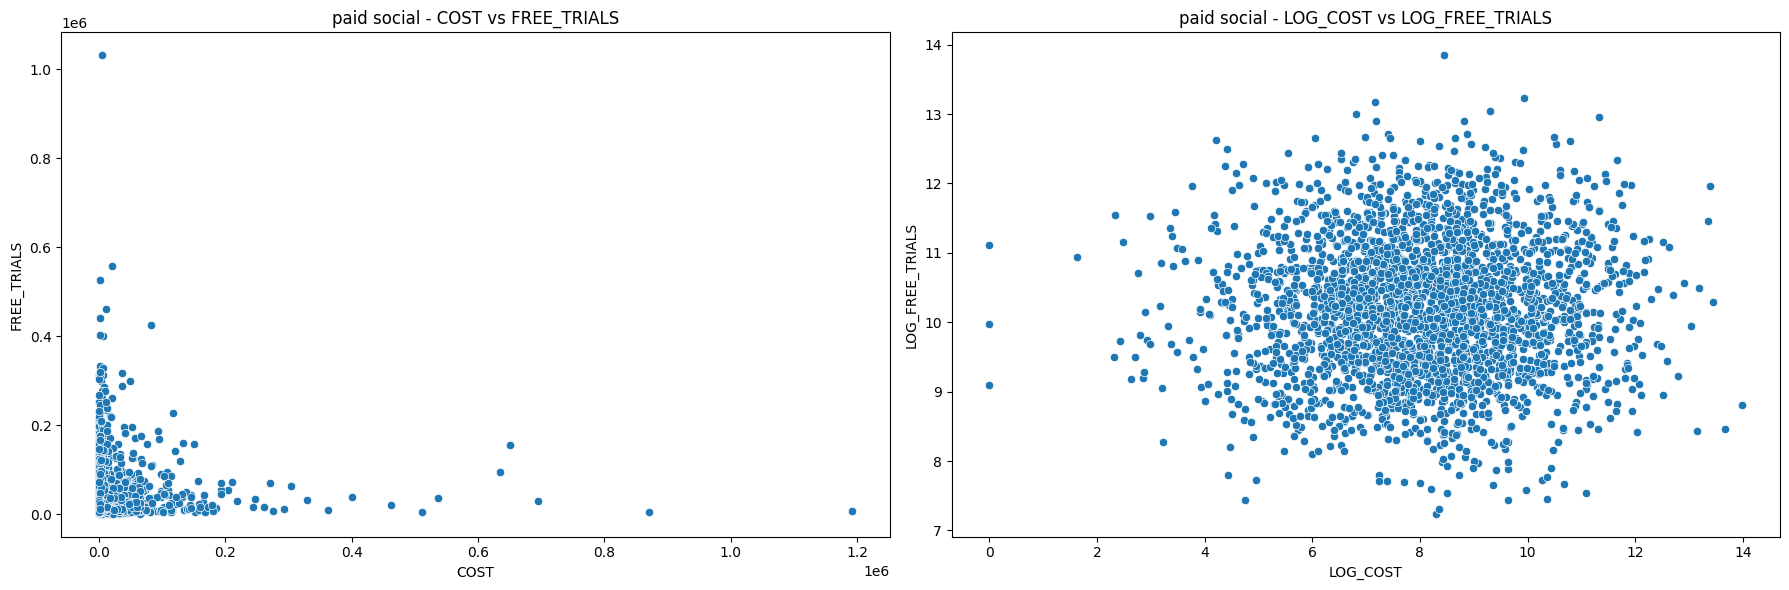

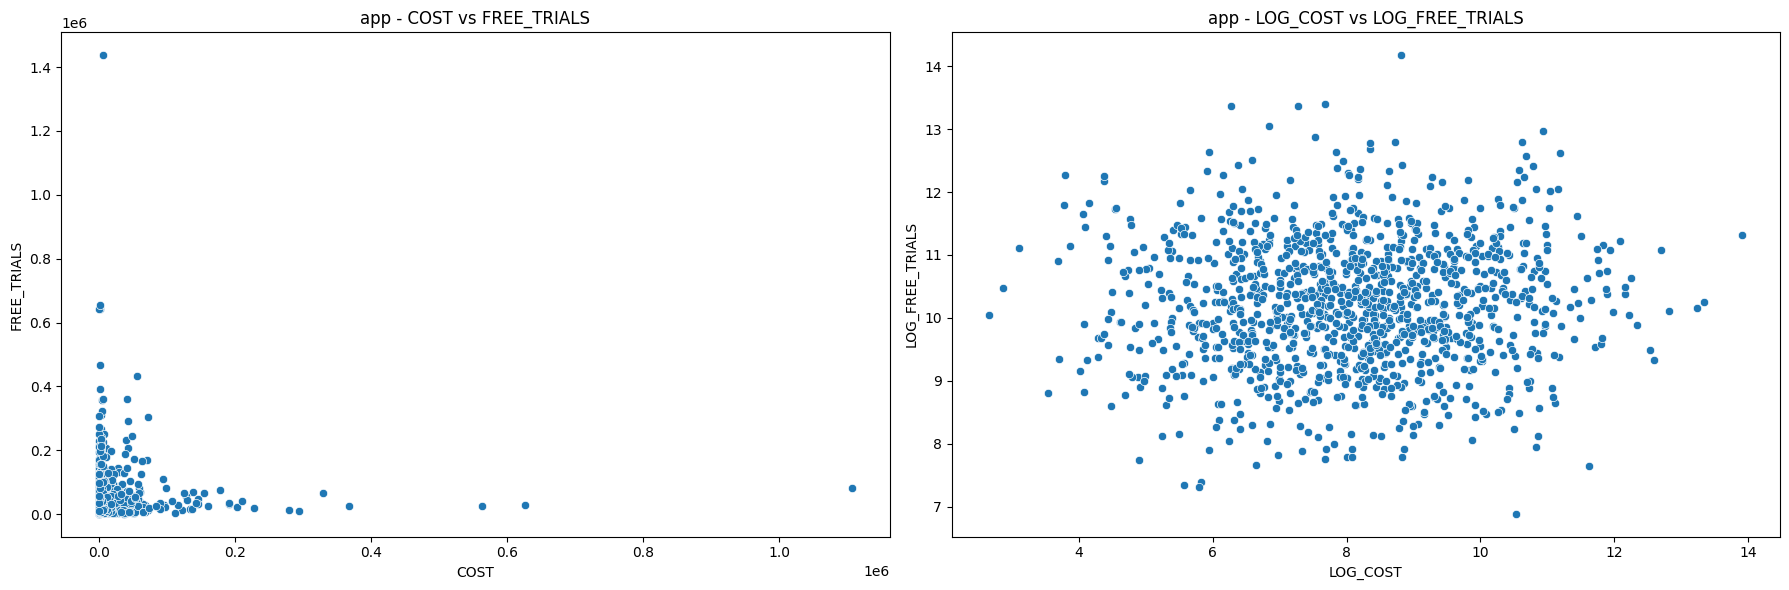

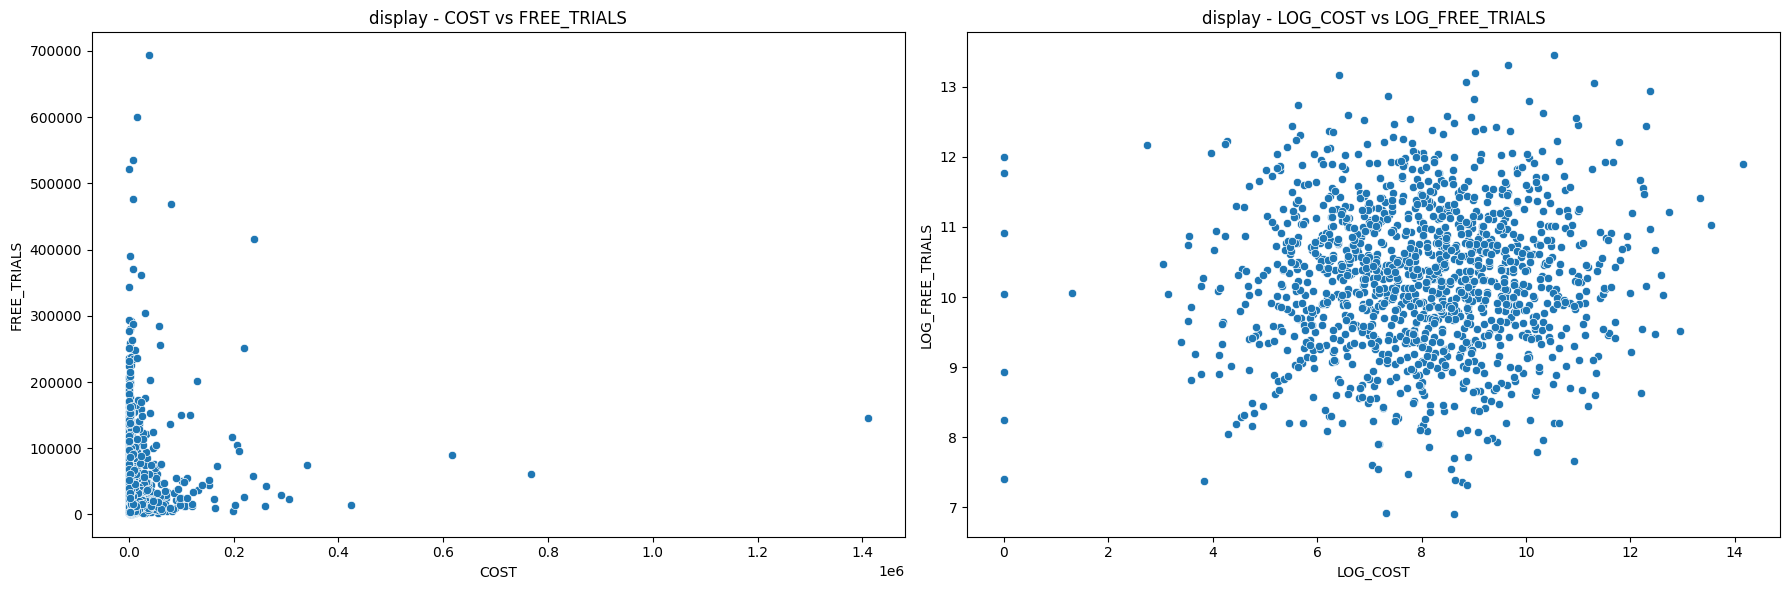

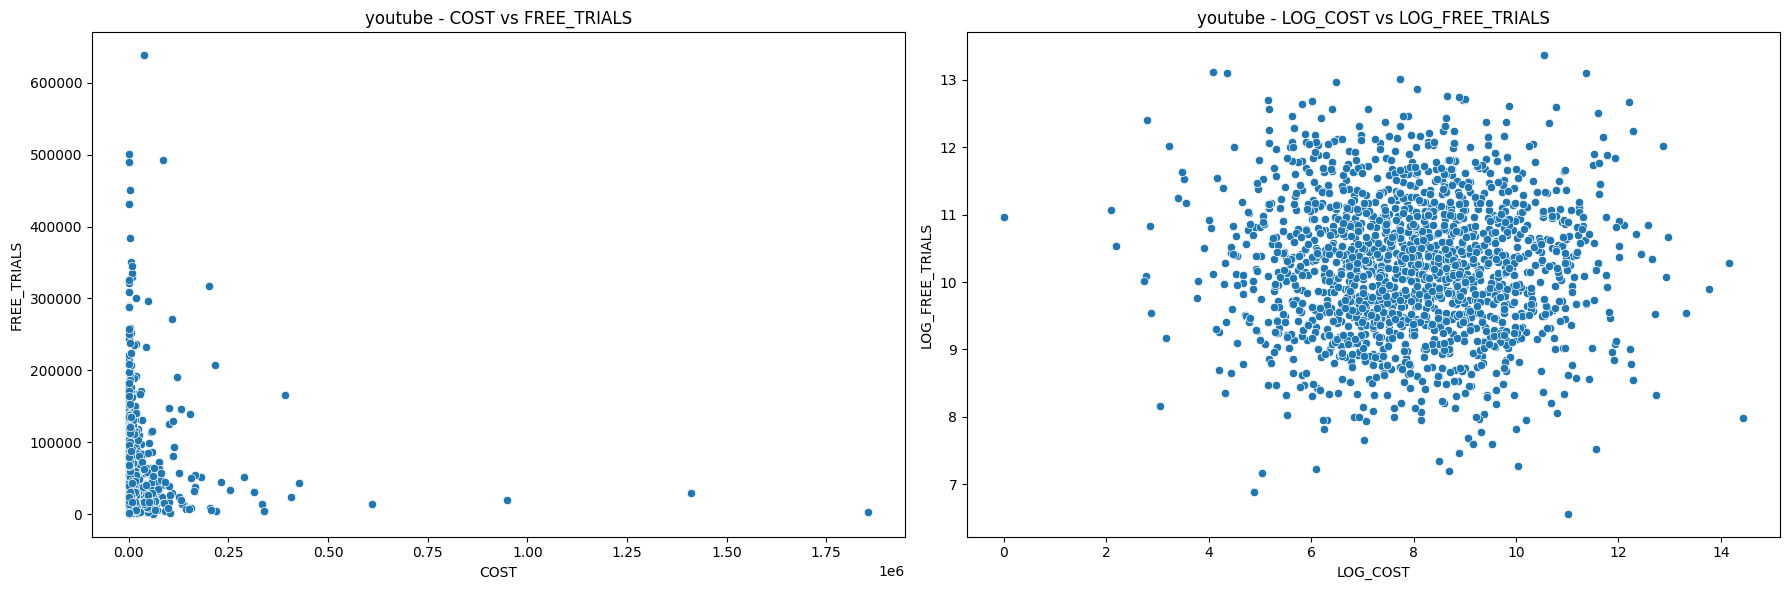

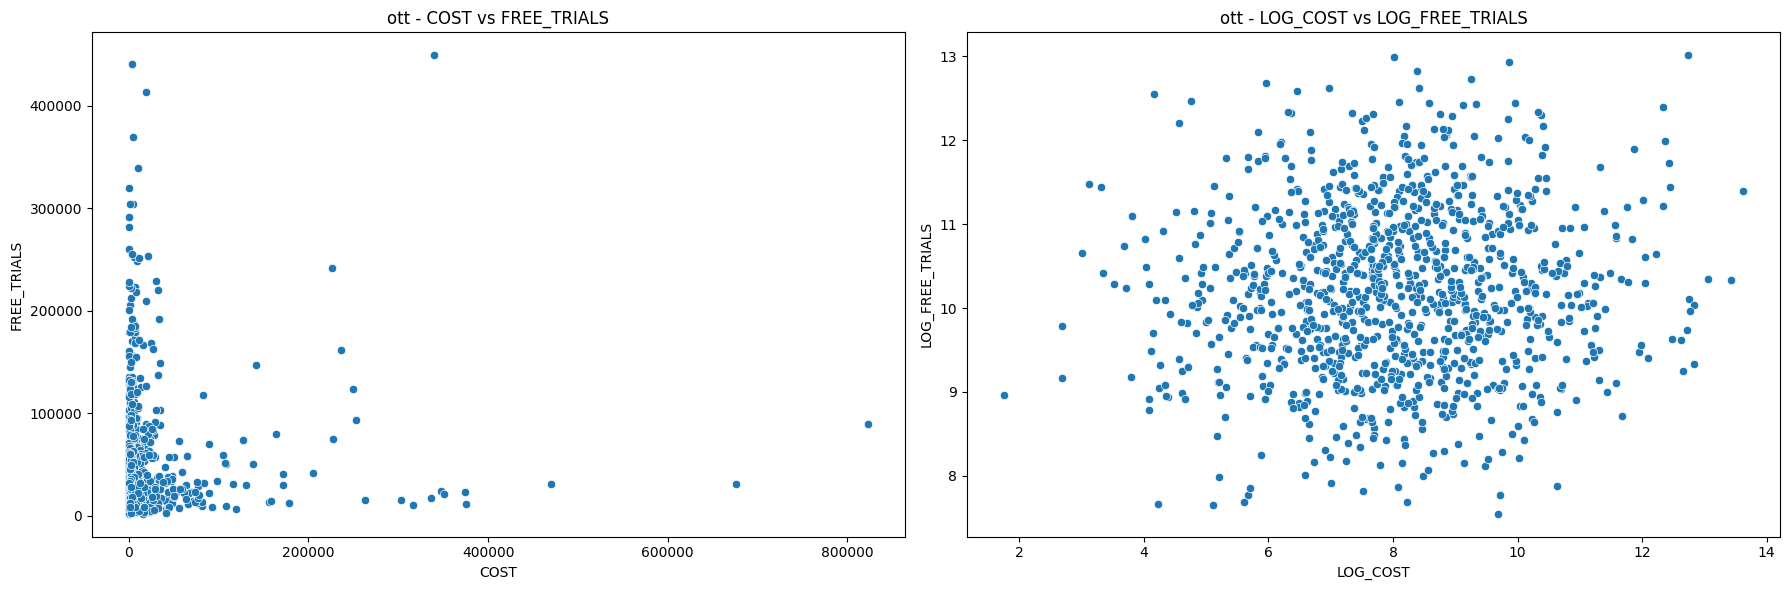

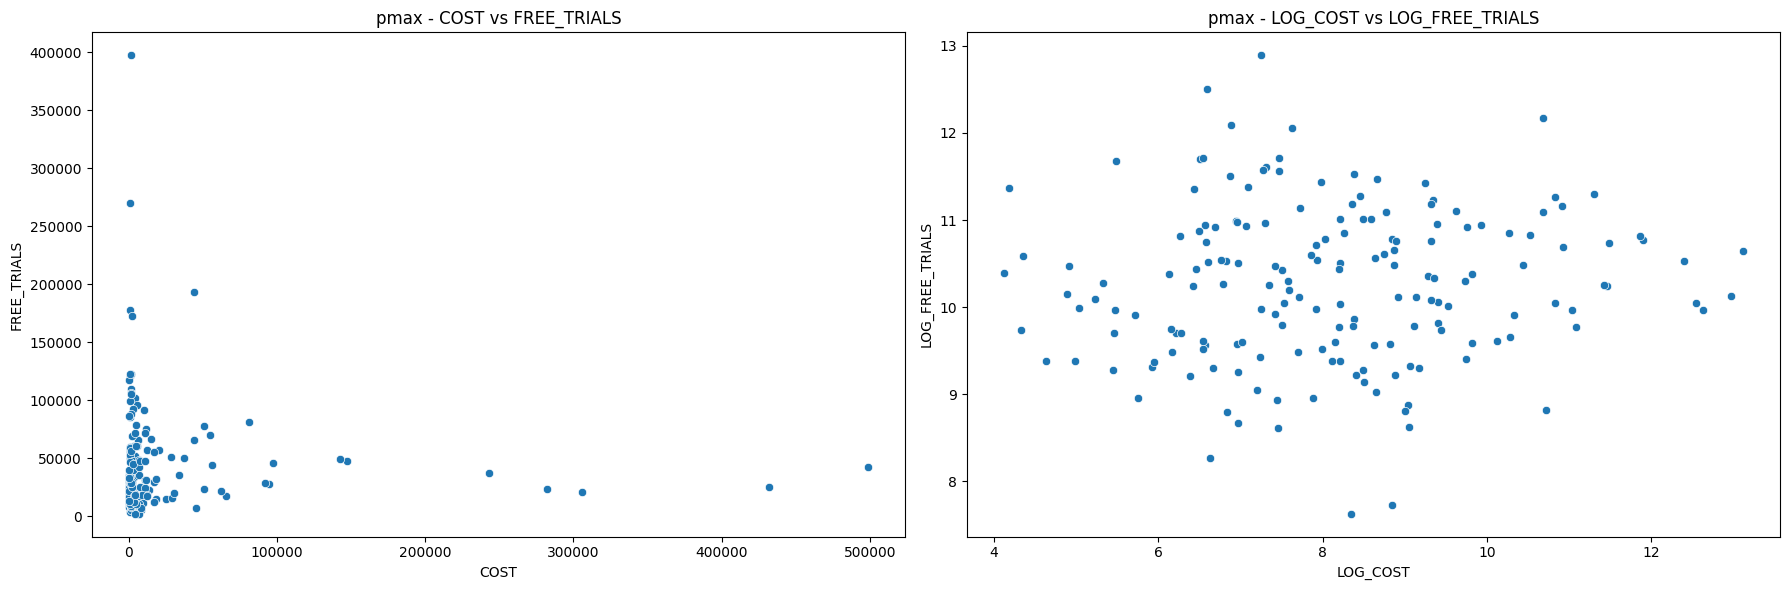

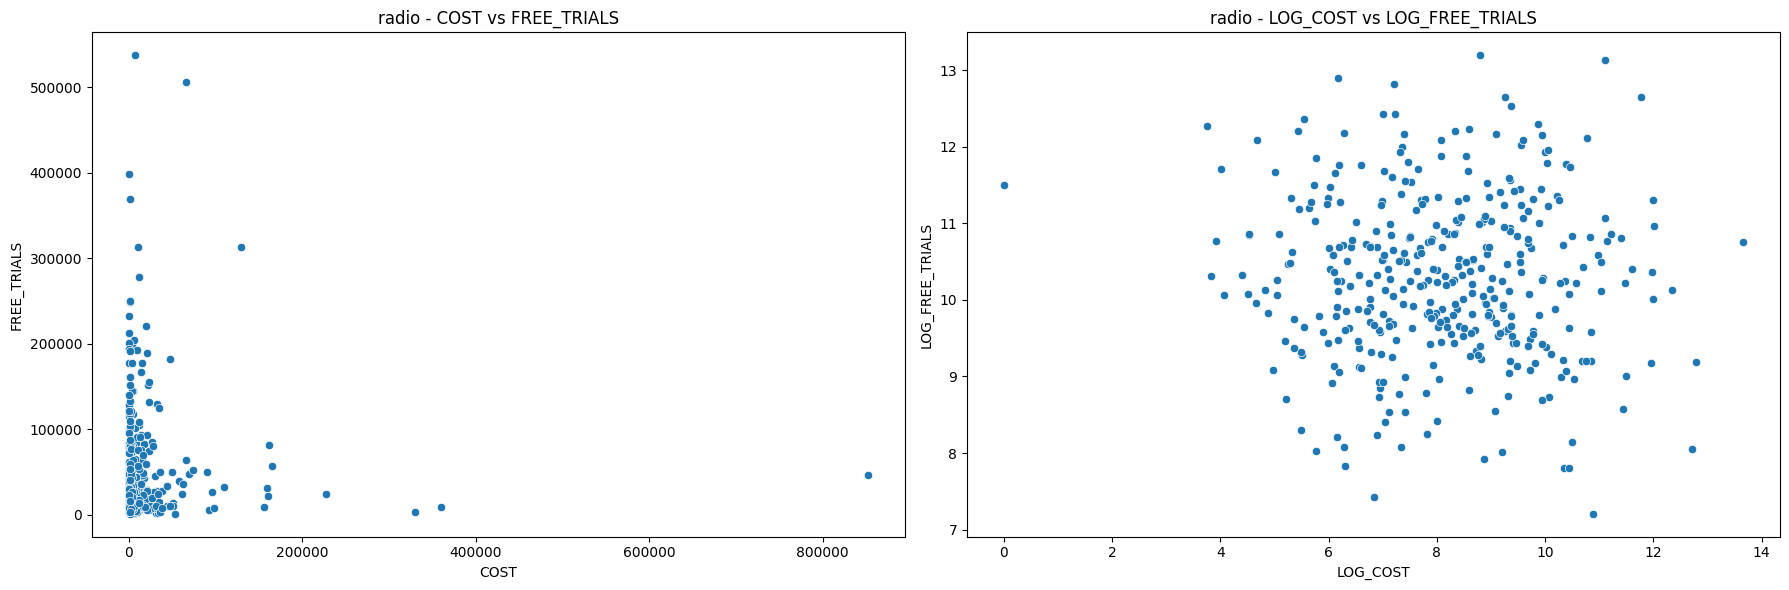

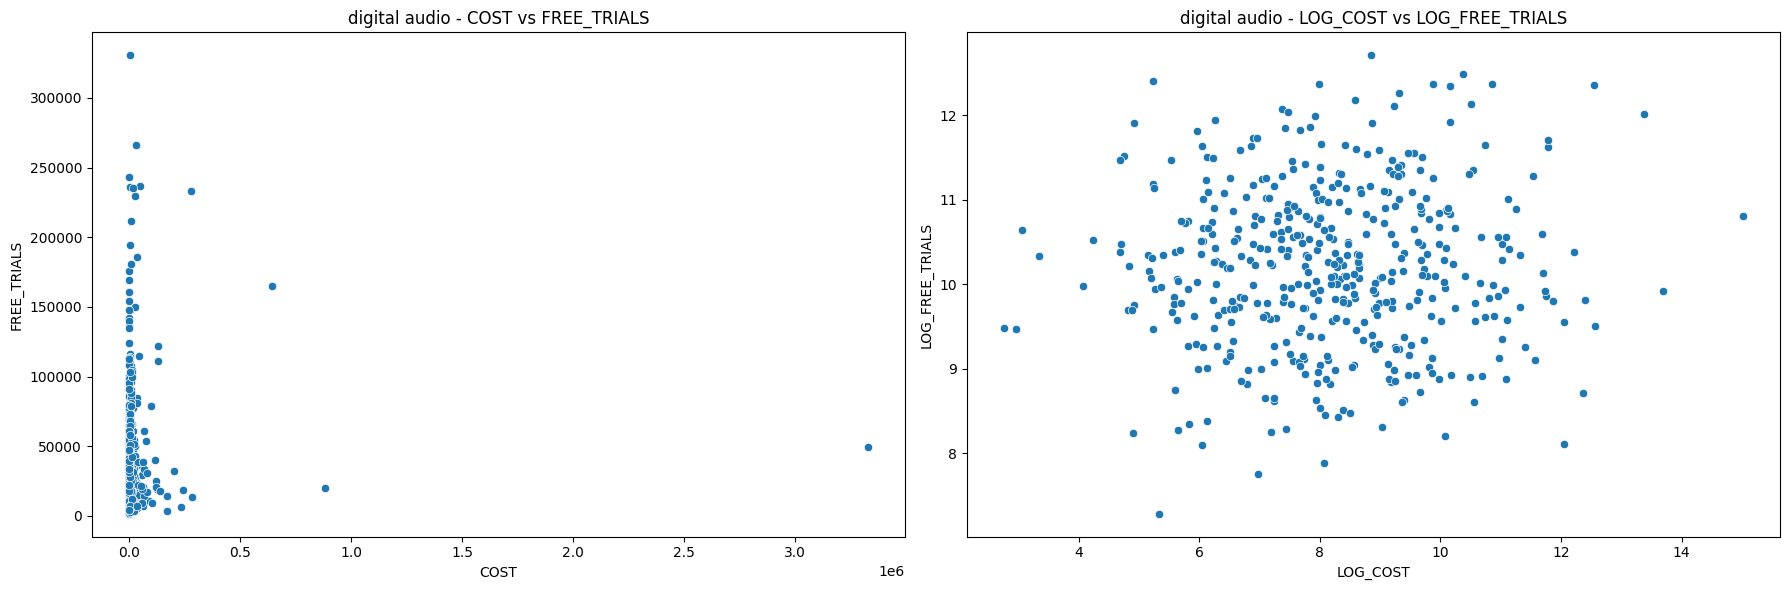

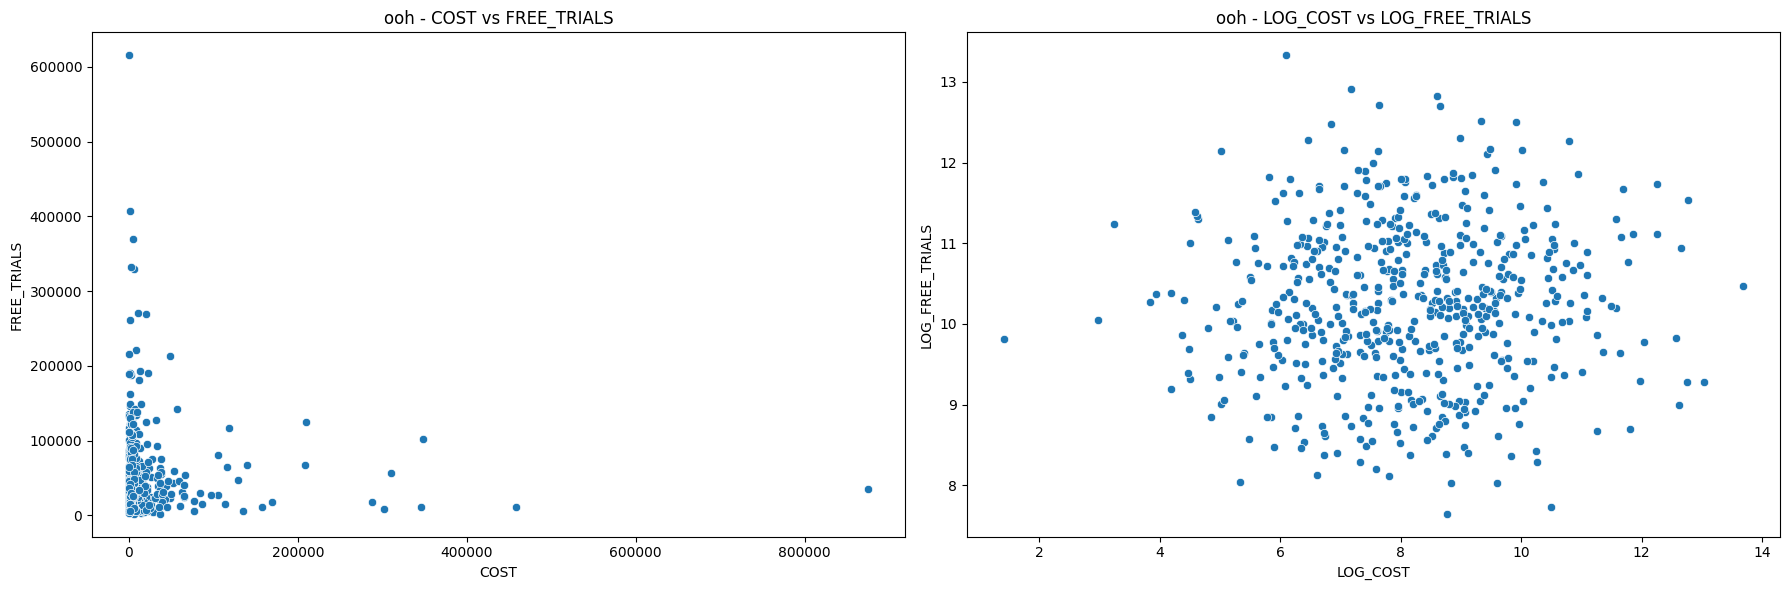

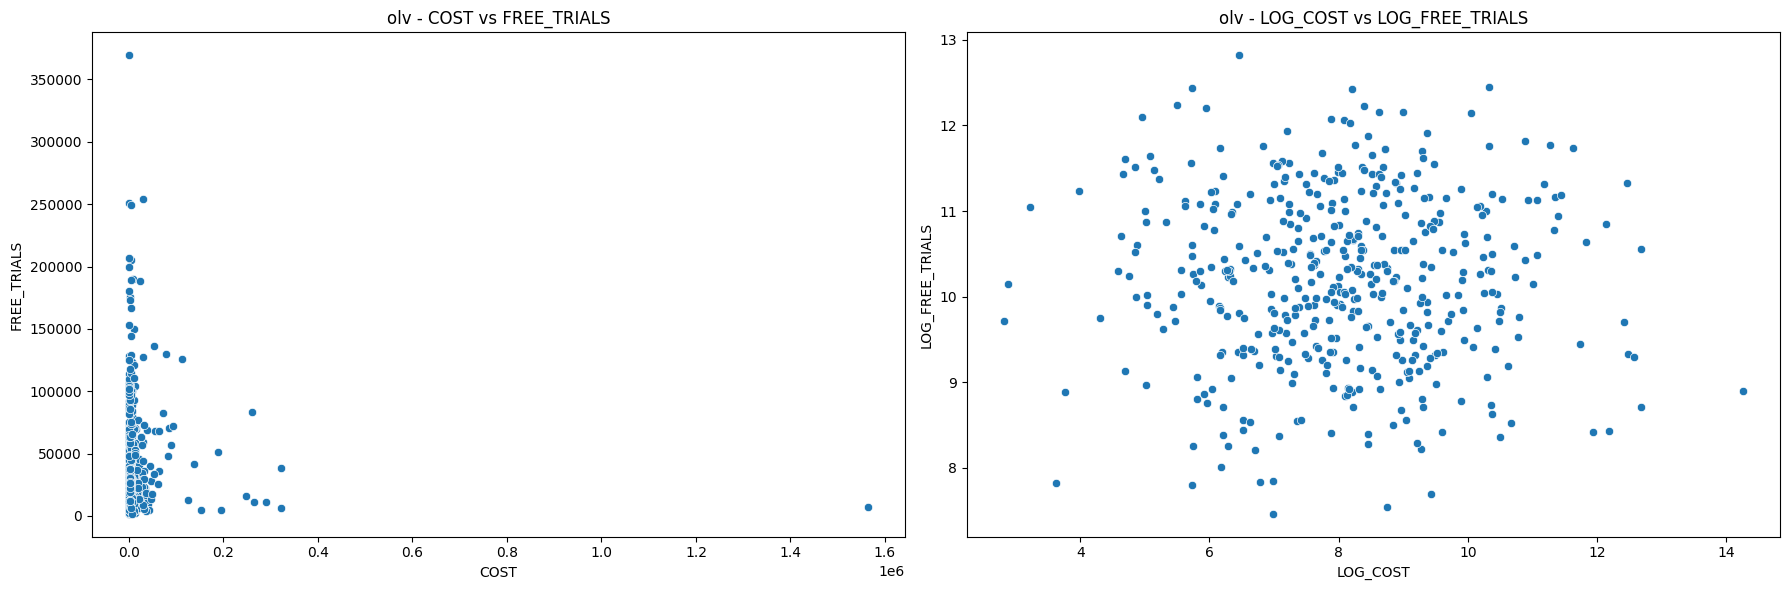

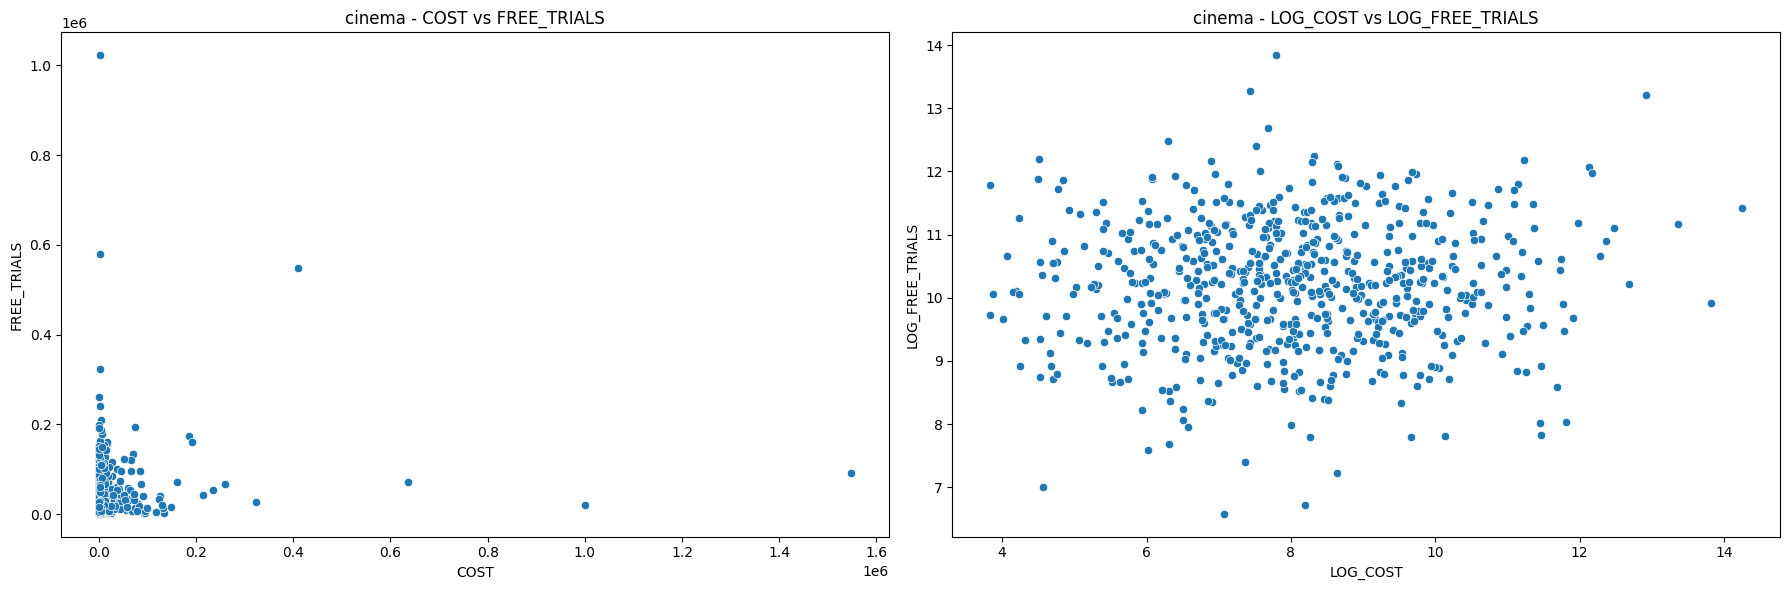

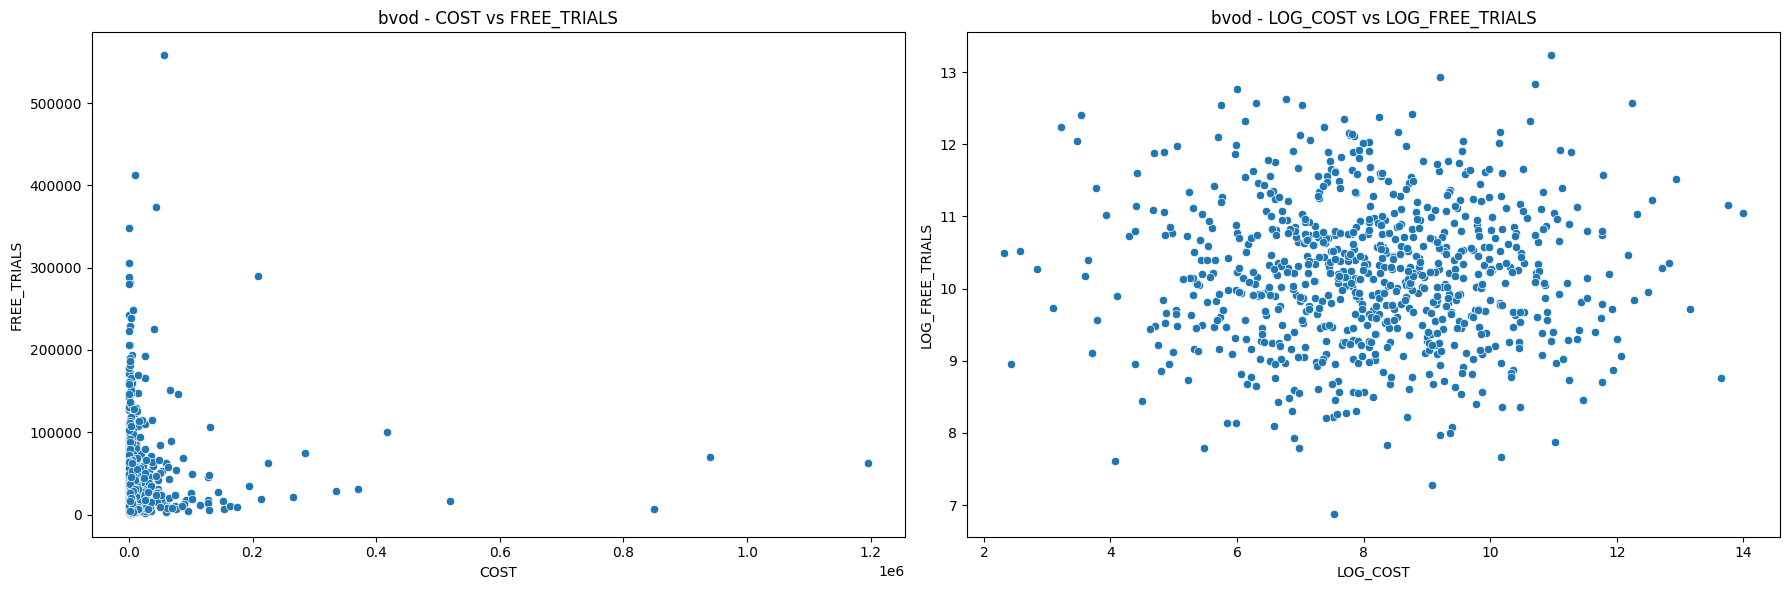

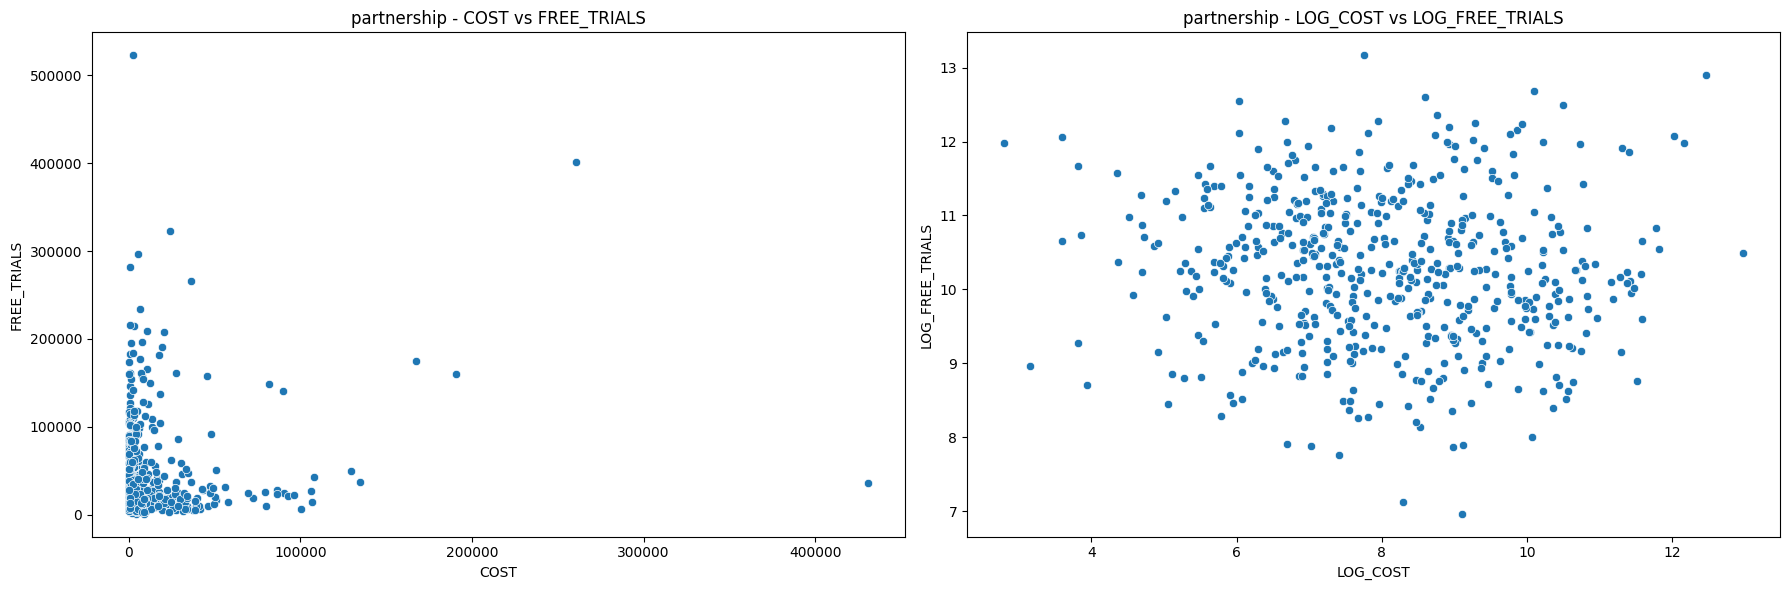

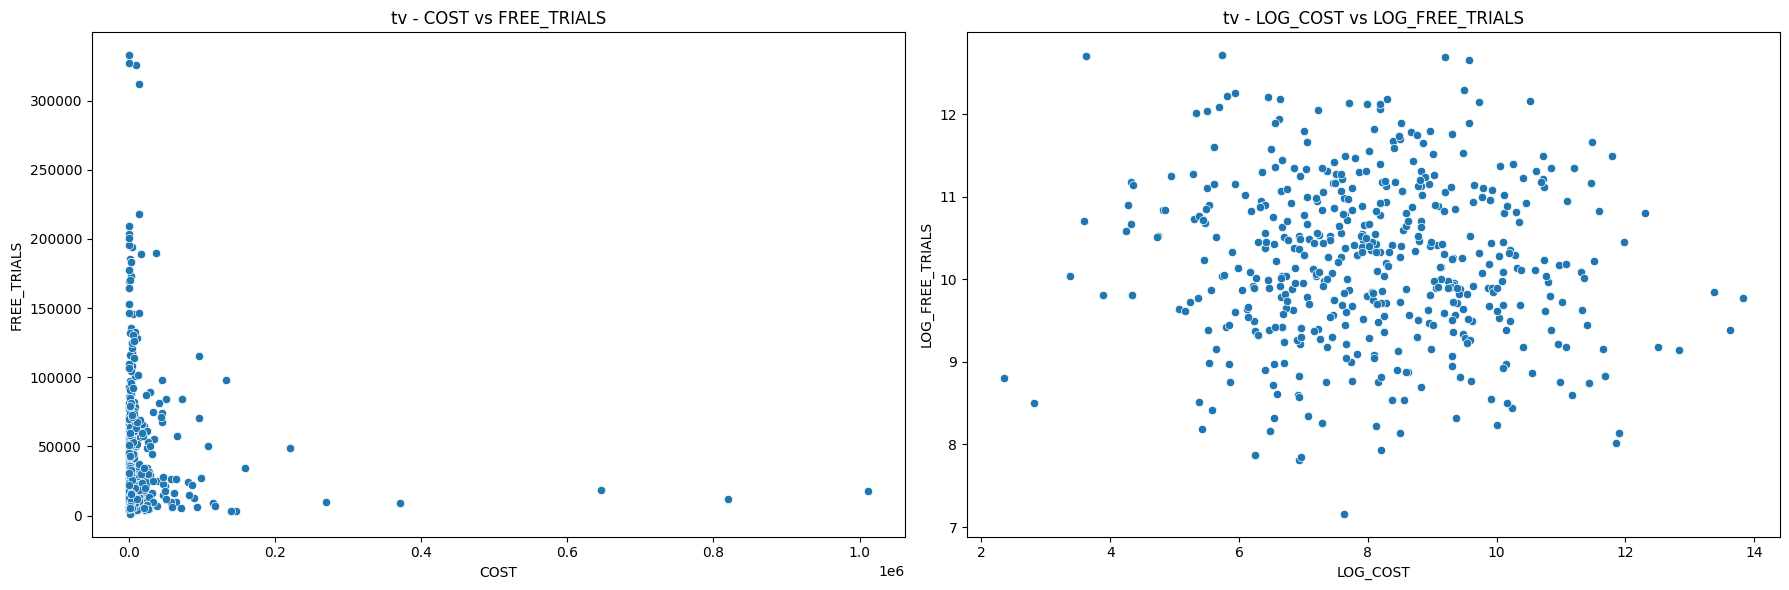

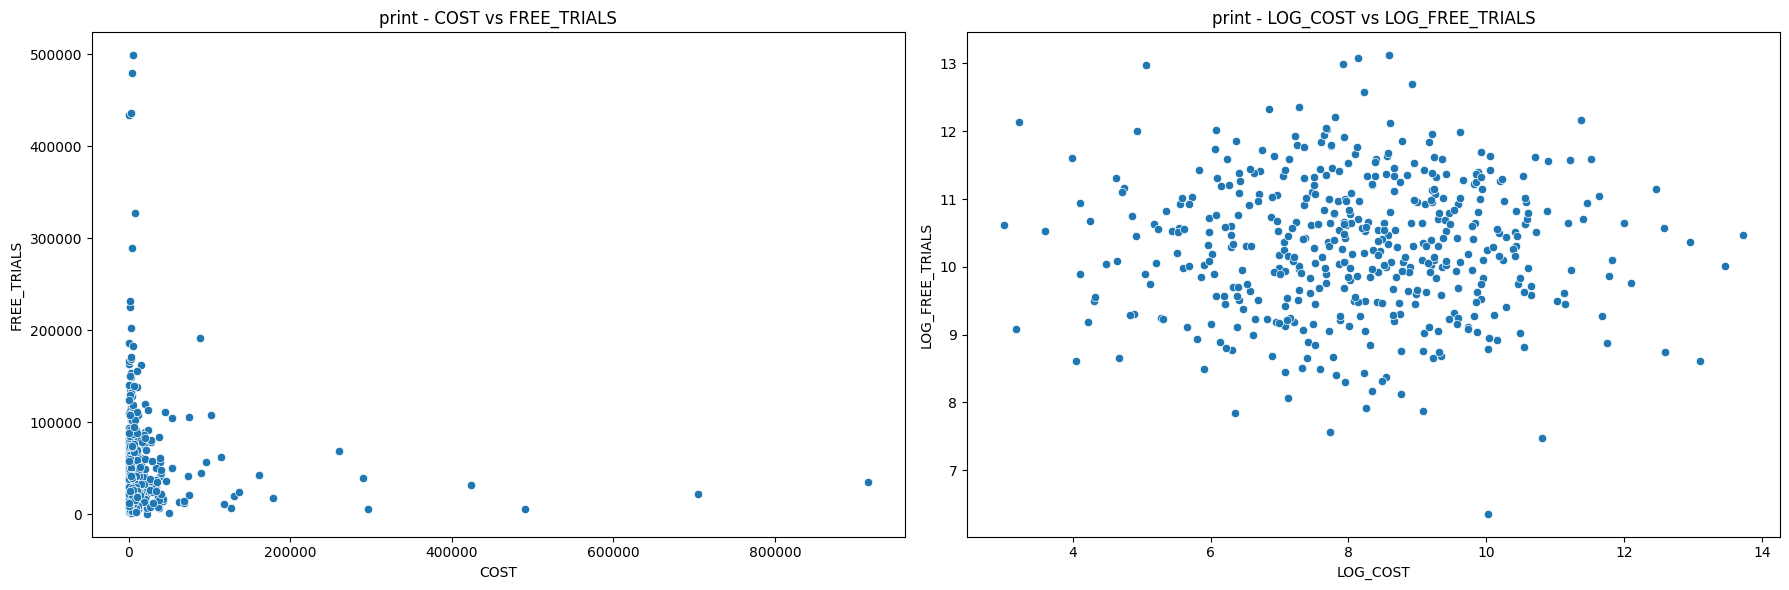

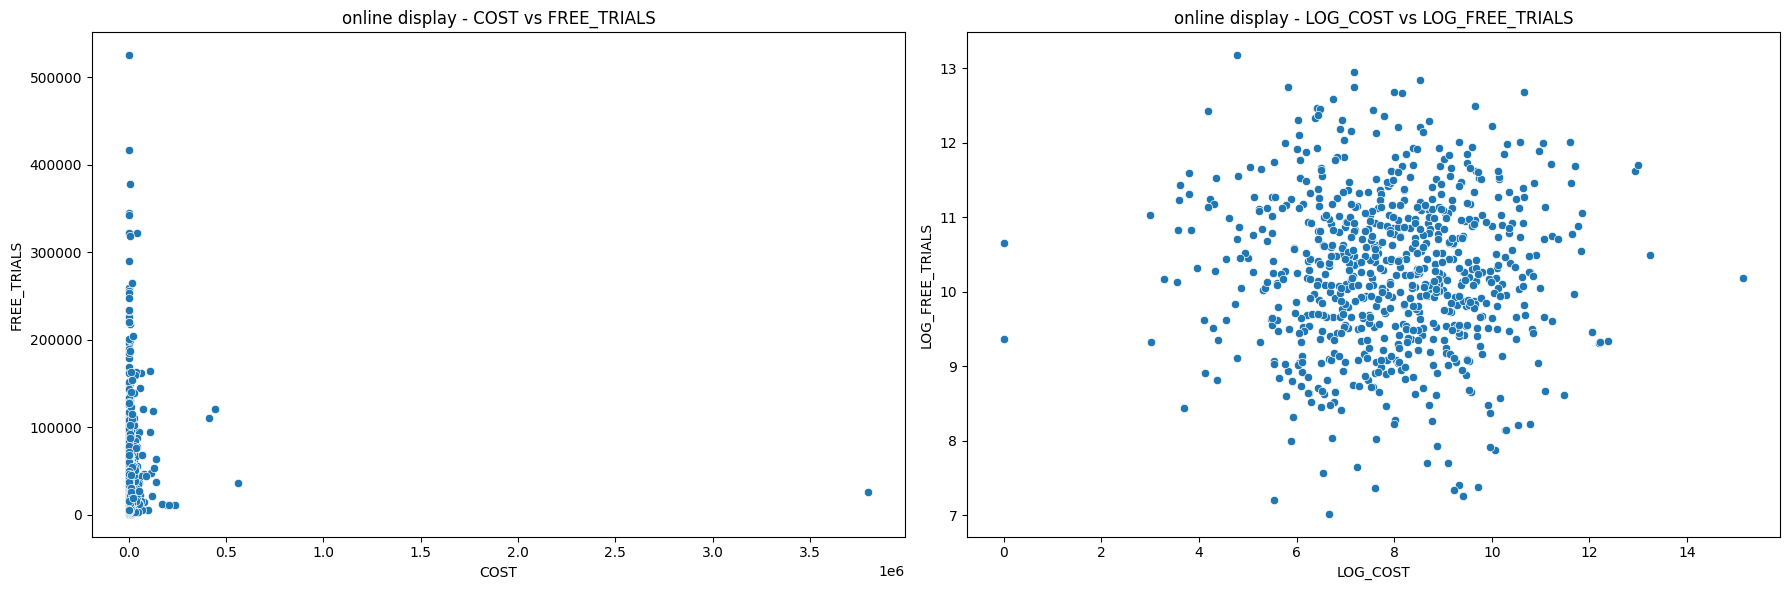

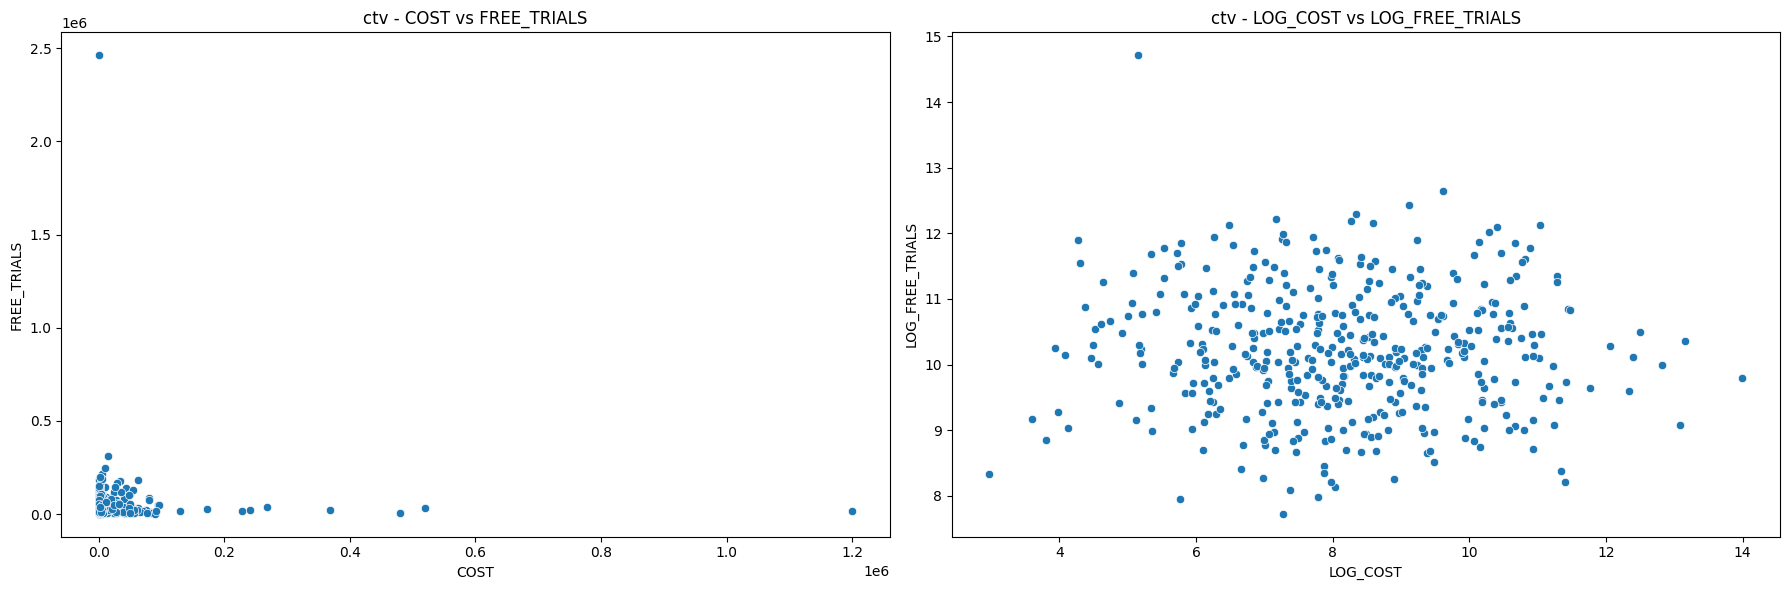

In [24]:
'''
1. When campaign spending is low, there’s higher variability in the number of free trials generated. For all visuals, as
spending increases (especially in paid social campaigns), there’s a diminishing return in the number of free trials generated.
Beyond a certain threshold (around the midpoint in the data), higher spending could lead to higher risks by the form of
fewer free trials.

2. Lot of campaigns that run on Pmax incur high expesnse. After looking into Pmax, these might involve higher upfront costs that decrease over time,
although current data lacks appropriate metadata since unsure when contracts were signed. Meanwhile, Digital Audio campaigns have a lower cost.
'''
values = list(df['CHANNEL'].unique())
for val in values:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create side-by-side plots

    data = df[df['CHANNEL'] == val]  # Filter the data for the current value

    # First scatter plot
    sns.scatterplot(data=data, x='COST', y='FREE_TRIALS', ax=axes[0])
    axes[0].set_title(f'{val} - COST vs FREE_TRIALS')
    axes[0].set_xlabel('COST')
    axes[0].set_ylabel('FREE_TRIALS')

    # Second scatter plot
    sns.scatterplot(data=data, x='LOG_COST', y='LOG_FREE_TRIALS', ax=axes[1])
    axes[1].set_title(f'{val} - LOG_COST vs LOG_FREE_TRIALS')
    axes[1].set_xlabel('LOG_COST')
    axes[1].set_ylabel('LOG_FREE_TRIALS')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [25]:
df

REPORT_DATE             ATL_OR_DR CAMPAIGN_TYPE      CHANNEL       COST  \
0      2023-06-09  DR - Direct Response         Title  paid social    7784.31   
1      2023-08-29  DR - Direct Response         Title          app    2474.31   
2      2023-07-23  ATL - Above The Line         Title  paid social   10222.82   
3      2023-12-23  DR - Direct Response         Title          app   49631.87   
4      2022-08-31  ATL - Above The Line         Title  paid social    2081.06   
...           ...                   ...           ...          ...        ...   
14103  2024-02-23  ATL - Above The Line         Brand         bvod    1478.78   
14104  2024-04-21  ATL - Above The Line         Title          ooh     839.25   
14105  2023-12-13  ATL - Above The Line         Title         bvod  193796.71   
14106  2023-02-04  ATL - Above The Line         Brand  paid social   84690.65   
14107  2023-02-17  DR - Direct Response         Title      youtube    7385.46   

       FREE_TRIALS  HOLIDAY_FLAG     MONTH     ATL_OR_DR_CAMPAIGN_TYPE  \
0         86401.15         False      June  DR - Direct Response_Title   
1          2956.74         False    August  DR - Direct Response_Title   
2         12513.08         False      July  ATL - Above The Line_Title   
3         17207.04          True  December  DR - Direct Response_Title   
4         21758.33         False    August  ATL - Above The Line_Title   
...            ...           ...       ...                         ...   
14103     16941.67         False  February  ATL - Above The Line_Brand   
14104      5727.03         False     April  ATL - Above The Line_Title   
14105     34824.51         False  December  ATL - Above The Line_Title   
14106     25140.77         False  February  ATL - Above The Line_Brand   
14107     17770.26         False  February  DR - Direct Response_Title   

              ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL  ... CAMPAIGN_TYPE_CHANNEL  \
0      DR - Direct Response_Title_paid social  ...     Title_paid social   
1              DR - Direct Response_Title_app  ...             Title_app   
2      ATL - Above The Line_Title_paid social  ...     Title_paid social   
3              DR - Direct Response_Title_app  ...             Title_app   
4      ATL - Above The Line_Title_paid social  ...     Title_paid social   
...                                       ...  ...                   ...   
14103         ATL - Above The Line_Brand_bvod  ...            Brand_bvod   
14104          ATL - Above The Line_Title_ooh  ...             Title_ooh   
14105         ATL - Above The Line_Title_bvod  ...            Title_bvod   
14106  ATL - Above The Line_Brand_paid social  ...     Brand_paid social   
14107      DR - Direct Response_Title_youtube  ...         Title_youtube   

      CAMPAIGN_TYPE_CHANNEL_MONTH CAMPAIGN_TYPE_MONTH         CHANNEL_MONTH  \
0          Title_paid social_June          Title_June      paid social_June   
1                Title_app_August        Title_August            app_August   
2          Title_paid social_July          Title_July      paid social_July   
3              Title_app_December      Title_December          app_December   
4        Title_paid social_August        Title_August    paid social_August   
...                           ...                 ...                   ...   
14103         Brand_bvod_February      Brand_February         bvod_February   
14104             Title_ooh_April         Title_April             ooh_April   
14105         Title_bvod_December      Title_December         bvod_December   
14106  Brand_paid social_February      Brand_February  paid social_February   
14107      Title_youtube_February      Title_February      youtube_February   

      COST_PER_FREE_TRIALS COST_BY_FREE_TRIALS   LOG_COST LOG_FREE_TRIALS  \
0                 0.090095        6.725733e+08   8.959994       11.366768   
1                 0.836837        7.315891e+06   7.814121        7.992181   
2                 0.816971        1.279190e+08   9.

In [26]:
categorical = list(set(df.columns) - set(quantitative))
categorical

['ATL_OR_DR_CAMPAIGN_TYPE_MONTH',
 'ATL_OR_DR_CAMPAIGN_TYPE',
 'ATL_OR_DR',
 'HOLIDAY_FLAG',
 'CAMPAIGN_TYPE_CHANNEL_MONTH',
 'ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL_MONTH',
 'CHANNEL',
 'CAMPAIGN_TYPE_MONTH',
 'CAMPAIGN_TYPE',
 'ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL',
 'MONTH',
 'CAMPAIGN_TYPE_CHANNEL',
 'REPORT_DATE',
 'ATL_OR_DR_CHANNEL',
 'ATL_OR_DR_MONTH',
 'CHANNEL_MONTH',
 'ATL_OR_DR_CHANNEL_MONTH']

In [27]:
categorical.remove('HOLIDAY_FLAG')
categorical.remove('ATL_OR_DR')

In [28]:
categorical

['ATL_OR_DR_CAMPAIGN_TYPE_MONTH',
 'ATL_OR_DR_CAMPAIGN_TYPE',
 'CAMPAIGN_TYPE_CHANNEL_MONTH',
 'ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL_MONTH',
 'CHANNEL',
 'CAMPAIGN_TYPE_MONTH',
 'CAMPAIGN_TYPE',
 'ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL',
 'MONTH',
 'CAMPAIGN_TYPE_CHANNEL',
 'REPORT_DATE',
 'ATL_OR_DR_CHANNEL',
 'ATL_OR_DR_MONTH',
 'CHANNEL_MONTH',
 'ATL_OR_DR_CHANNEL_MONTH']

In [29]:
'''
Kruskal-Wallis H test is the equivalent to ANOVA but uses medians instead. ANOVA assumes data is normally distributed.
'''

from scipy import stats
# Initialize an empty list to store results
anova_results = []

# Loop through each categorical and quantitative combination
for category_dimension in categorical:
    for quant in quantitative:
        # Step 1: Get unique categories
        categories = df[category_dimension].unique()

        # Step 2: Group data by category
        grouped_data = {}
        for category in categories:
            grouped_data[category] = df[df[category_dimension] == category][quant].values

        # Step 3: Convert grouped data to a list of arrays
        grouped_data_list = list(grouped_data.values())

        # Step 4: Perform one-way ANOVA
        try:
            anova_result = stats.f_oneway(*grouped_data_list)
            # Append results to the list
            anova_results.append({
                "Categorical Variable": category_dimension,
                "Quantitative Variable": quant,
                "F-statistic": anova_result.statistic,
                "p-value": anova_result.pvalue
            })
        except ValueError as e:
            # Handle errors and append to the results
            anova_results.append({
                "Categorical Variable": category_dimension,
                "Quantitative Variable": quant,
                "F-statistic": None,
                "p-value": None,
                "Error": str(e)
            })

# Convert the results to a DataFrame
anova_results_df = pd.DataFrame(anova_results)
anova_results_df.sort_values('p-value', inplace=True, ascending=True)
anova_results_df

Categorical Variable     Quantitative Variable  \
19             CAMPAIGN_TYPE_CHANNEL_MONTH       COST_BY_FREE_TRIALS   
43                     CAMPAIGN_TYPE_MONTH       COST_BY_FREE_TRIALS   
114                ATL_OR_DR_CHANNEL_MONTH      COST_PER_FREE_TRIALS   
27   ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL_MONTH       COST_BY_FREE_TRIALS   
30   ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL_MONTH  LOG_COST_PER_FREE_TRIALS   
..                                     ...                       ...   
13                 ATL_OR_DR_CAMPAIGN_TYPE           LOG_FREE_TRIALS   
74                   CAMPAIGN_TYPE_CHANNEL      COST_PER_FREE_TRIALS   
83                             REPORT_DATE       COST_BY_FREE_TRIALS   
80                             REPORT_DATE                      COST   
18             CAMPAIGN_TYPE_CHANNEL_MONTH      COST_PER_FREE_TRIALS   

     F-statistic   p-value  
19      1.232459  0.002151  
43      1.847374  0.004176  
114     1.259634  0.004305  
27      1.177083  0.007635  
30      1.134532  0.030596  
..           ...       ...  
13      0.223396  0.925475  
74      0.660788  0.955366  
83      0.904979  0.962246  
80      0.890414  0.980485  
18      0.804772  0.996792  

[120 rows x 4 columns]

In [30]:
# filtered_df = anova_results_df[
#     (anova_results_df['p-value'] <= 0.06) &
#     (

#         (anova_results_df['Quantitative Variable'] == 'LOG_COST') |
#         (anova_results_df['Quantitative Variable'] == 'LOG_FREE_TRIALS')
#     )
# ]
# filtered_df
anova_results_df[(anova_results_df['p-value'] <=.06)]

Categorical Variable     Quantitative Variable  \
19             CAMPAIGN_TYPE_CHANNEL_MONTH       COST_BY_FREE_TRIALS   
43                     CAMPAIGN_TYPE_MONTH       COST_BY_FREE_TRIALS   
114                ATL_OR_DR_CHANNEL_MONTH      COST_PER_FREE_TRIALS   
27   ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL_MONTH       COST_BY_FREE_TRIALS   
30   ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL_MONTH  LOG_COST_PER_FREE_TRIALS   
72                   CAMPAIGN_TYPE_CHANNEL                      COST   
64                                   MONTH                      COST   
67                                   MONTH       COST_BY_FREE_TRIALS   
102                        ATL_OR_DR_MONTH  LOG_COST_PER_FREE_TRIALS   
56         ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL                      COST   
65                                   MONTH               FREE_TRIALS   

     F-statistic   p-value  
19      1.232459  0.002151  
43      1.847374  0.004176  
114     1.259634  0.004305  
27      1.177083  0.007635  
30      1.134532  0.030596  
72      1.439863  0.032500  
64      1.866424  0.038672  
67      1.794193  0.049204  
102     1.531797  0.049530  
56      1.348042  0.051274  
65      1.745376  0.057730

In [31]:
CAMPAIGN_TYPE_CHANNEL_TO_COST_MEAN_hashmap = df.groupby('CAMPAIGN_TYPE_CHANNEL')['COST'].mean().to_dict()
CAMPAIGN_TYPE_CHANNEL_TO_COST_MEDIAN_hashmap = df.groupby('CAMPAIGN_TYPE_CHANNEL')['COST'].median().to_dict()

#

MONTH_TO_COST_MEAN_hashmap = df.groupby('MONTH')['COST'].mean().to_dict()
MONTH_TO_COST_MEDIAN_hashmap = df.groupby('MONTH')['COST'].median().to_dict()


MONTH_TO_FREE_TRIALS_MEAN_hashmap = df.groupby('MONTH')['FREE_TRIALS'].mean().to_dict()
MONTH_TO_FREE_TRIALS_MEDIAN_hashmap = df.groupby('MONTH')['FREE_TRIALS'].median().to_dict()

In [32]:
df['AVG_COST_MONTH'] = df['MONTH'].map(MONTH_TO_COST_MEAN_hashmap)
df['MEDIAN_COST_MONTH'] = df['MONTH'].map(MONTH_TO_COST_MEDIAN_hashmap)
#

df['AVG_COST_CAMPAIGN_TYPE_CHANNEL'] = df['CAMPAIGN_TYPE_CHANNEL'].map(CAMPAIGN_TYPE_CHANNEL_TO_COST_MEAN_hashmap)
df['MEDIAN_COST_CAMPAIGN_TYPE_CHANNEL'] = df['CAMPAIGN_TYPE_CHANNEL'].map(CAMPAIGN_TYPE_CHANNEL_TO_COST_MEDIAN_hashmap)


df['AVG_FREE_TRIALS_MONTH'] = df['MONTH'].map(MONTH_TO_FREE_TRIALS_MEAN_hashmap)
df['MEDIAN_FREE_TRIALS_MONTH'] = df['MONTH'].map(MONTH_TO_FREE_TRIALS_MEDIAN_hashmap)

In [33]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# results = pairwise_tukeyhsd(endog=df['FREE_TRIALS'], groups=df['MONTH'])
# print(results)


In [34]:
# Group the COST_PER_FREE_TRIALS by the ATL_OR_DR categories
grouped_data = df.groupby('MONTH')['COST'].apply(list)

# Perform a one-way ANOVA test
anova_result = f_oneway(*grouped_data)

# Display the ANOVA test results
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

F-statistic: 1.8664244222010298
p-value: 0.03867191009227552


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14108 entries, 0 to 14107
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   REPORT_DATE                            14108 non-null  datetime64[ns]
 1   ATL_OR_DR                              14108 non-null  object        
 2   CAMPAIGN_TYPE                          14108 non-null  object        
 3   CHANNEL                                14108 non-null  object        
 4   COST                                   14108 non-null  float64       
 5   FREE_TRIALS                            14108 non-null  float64       
 6   HOLIDAY_FLAG                           14108 non-null  bool          
 7   MONTH                                  14108 non-null  object        
 8   ATL_OR_DR_CAMPAIGN_TYPE                14108 non-null  object        
 9   ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL        14108 non-null  object

In [36]:
# # categorical = ['ATL_OR_DR', 'HOLIDAY_FLAG']
# from scipy.stats import ttest_1samp

# # Group the COST data by the MONTH categories
# grouped_data = df.groupby('MONTH')['FREE_TRIALS'].apply(list)

# # Define the population mean to compare against
# population_mean = 50  # Replace with your desired mean value

# # Perform a one-sample t-test for each group
# for month, data in grouped_data.items():
#     t_test_result = ttest_1samp(data, population_mean)
#     print(f"Month: {month}")
#     print(f"T-statistic: {t_test_result.statistic}")
#     print(f"P-value: {t_test_result.pvalue}")
#     print()

# # # Define the population mean to compare against
# # population_mean = 50  # Replace with the desired mean value

# # # Initialize an empty list to store results
# # t_test_results = []

# # # Loop through each categorical and quantitative combination
# # for category_dimension in categorical:
# #     for quant in quantitative:
# #         # Step 1: Get unique categories
# #         categories = df[category_dimension].unique()

# #         # Step 2: Group data by category
# #         grouped_data = {}
# #         for category in categories:
# #             grouped_data[category] = df[df[category_dimension] == category][quant].values

# #         # Step 3: Perform one-sample t-test for each category
# #         for category, values in grouped_data.items():
# #             try:
# #                 # Perform one-sample t-test
# #                 t_test_result = stats.ttest_1samp(values, population_mean)

# #                 # Append results to the list
# #                 t_test_results.append({
# #                     "Categorical Variable": category_dimension,
# #                     "Category": category,
# #                     "Quantitative Variable": quant,
# #                     "T-statistic": t_test_result.statistic,
# #                     "p-value": t_test_result.pvalue,
# #                     "Mean": values.mean()
# #                 })
# #             except ValueError as e:
# #                 # Handle errors and append to the results
# #                 t_test_results.append({
# #                     "Categorical Variable": category_dimension,
# #                     "Category": category,
# #                     "Quantitative Variable": quant,
# #                     "T-statistic": None,
# #                     "p-value": None,
# #                     "Mean": None,
# #                     "Error": str(e)
# #                 })

# # # Convert the results to a DataFrame
# # t_test_results_df = pd.DataFrame(t_test_results)

# # # Sort results by p-value
# # t_test_results_df.sort_values('p-value', inplace=True, ascending=True)

# # # Display the results
# # t_test_results_df


In [37]:
# df.drop(columns='REPORT_DATE', axis=1, inplace=True)
# df.to_csv('../../data/log_data_fe_reducedoutliers.csv', index=False)

In [38]:
df

REPORT_DATE             ATL_OR_DR CAMPAIGN_TYPE      CHANNEL       COST  \
0      2023-06-09  DR - Direct Response         Title  paid social    7784.31   
1      2023-08-29  DR - Direct Response         Title          app    2474.31   
2      2023-07-23  ATL - Above The Line         Title  paid social   10222.82   
3      2023-12-23  DR - Direct Response         Title          app   49631.87   
4      2022-08-31  ATL - Above The Line         Title  paid social    2081.06   
...           ...                   ...           ...          ...        ...   
14103  2024-02-23  ATL - Above The Line         Brand         bvod    1478.78   
14104  2024-04-21  ATL - Above The Line         Title          ooh     839.25   
14105  2023-12-13  ATL - Above The Line         Title         bvod  193796.71   
14106  2023-02-04  ATL - Above The Line         Brand  paid social   84690.65   
14107  2023-02-17  DR - Direct Response         Title      youtube    7385.46   

       FREE_TRIALS  HOLIDAY_FLAG     MONTH     ATL_OR_DR_CAMPAIGN_TYPE  \
0         86401.15         False      June  DR - Direct Response_Title   
1          2956.74         False    August  DR - Direct Response_Title   
2         12513.08         False      July  ATL - Above The Line_Title   
3         17207.04          True  December  DR - Direct Response_Title   
4         21758.33         False    August  ATL - Above The Line_Title   
...            ...           ...       ...                         ...   
14103     16941.67         False  February  ATL - Above The Line_Brand   
14104      5727.03         False     April  ATL - Above The Line_Title   
14105     34824.51         False  December  ATL - Above The Line_Title   
14106     25140.77         False  February  ATL - Above The Line_Brand   
14107     17770.26         False  February  DR - Direct Response_Title   

              ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL  ...   LOG_COST LOG_FREE_TRIALS  \
0      DR - Direct Response_Title_paid social  ...   8.959994       11.366768   
1              DR - Direct Response_Title_app  ...   7.814121        7.992181   
2      ATL - Above The Line_Title_paid social  ...   9.232476        9.434610   
3              DR - Direct Response_Title_app  ...  10.812409        9.753132   
4      ATL - Above The Line_Title_paid social  ...   7.641113        9.987798   
...                                       ...  ...        ...             ...   
14103         ATL - Above The Line_Brand_bvod  ...   7.299649        9.737591   
14104          ATL - Above The Line_Title_ooh  ...   6.733699        8.653127   
14105         ATL - Above The Line_Title_bvod  ...  12.174570       10.458105   
14106  ATL - Above The Line_Brand_paid social  ...  11.346772       10.132286   
14107      DR - Direct Response_Title_youtube  ...   8.907404        9.785338   

      LOG_COST_PER_FREE_TRIALS LOG_COST_BY_FREE_TRIALS AVG_COST_MONTH  \
0                     0.086265               20.326622   16887.563506   
1                     0.608045               15.805560   14172.931604   
2                     0.597171               18.666908   13667.902515   
3                     1.356967               20.565462   18937.983302   
4                     0.091343               17.628385   14172.931604   
...                        ...                     ...            ...   
14103                 0.083685               17.036504   13900.634352   
14104                 0.136750               15.385461   14257.447211   
14105                 1.881745               22.632642   18937.983302   
14106                 1.474456               21.479007   13900.634352   
14107                 0.347559               18.692550   13900.634352   

      MEDIAN_COST_MONTH AVG_COST_CAMPAIGN_TYPE_CHANNEL  \
0              3643.265                   14781.334567   
1              2955.060                   15454.451540   
2              2994.470                   14781.334567   
3              3240.025                   15454.451540   
4   

In [39]:
categorize_columns(df)

{'categorical': ['ATL_OR_DR',
  'CAMPAIGN_TYPE',
  'CHANNEL',
  'HOLIDAY_FLAG',
  'MONTH',
  'ATL_OR_DR_CAMPAIGN_TYPE',
  'ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL',
  'ATL_OR_DR_CAMPAIGN_TYPE_CHANNEL_MONTH',
  'ATL_OR_DR_CAMPAIGN_TYPE_MONTH',
  'ATL_OR_DR_CHANNEL',
  'ATL_OR_DR_CHANNEL_MONTH',
  'ATL_OR_DR_MONTH',
  'CAMPAIGN_TYPE_CHANNEL',
  'CAMPAIGN_TYPE_CHANNEL_MONTH',
  'CAMPAIGN_TYPE_MONTH',
  'CHANNEL_MONTH'],
 'numerical': ['COST',
  'FREE_TRIALS',
  'COST_PER_FREE_TRIALS',
  'COST_BY_FREE_TRIALS',
  'LOG_COST',
  'LOG_FREE_TRIALS',
  'LOG_COST_PER_FREE_TRIALS',
  'LOG_COST_BY_FREE_TRIALS',
  'AVG_COST_MONTH',
  'MEDIAN_COST_MONTH',
  'AVG_COST_CAMPAIGN_TYPE_CHANNEL',
  'MEDIAN_COST_CAMPAIGN_TYPE_CHANNEL',
  'AVG_FREE_TRIALS_MONTH',
  'MEDIAN_FREE_TRIALS_MONTH'],
 'miscellaneous': ['REPORT_DATE']}

In [40]:
# df.drop(columns='REPORT_DATE', axis=1, inplace=True)
# df.to_csv('../../data/featured_engineered_testing.csv', index=False)